First, create a new conda environment named BI2025 and install the required packages from requirements.txt


In [57]:
#!conda create -n BI2025 python=3.11 -y
#!conda activate BI2025
#!pip install -r requirements.txt

In [58]:
# DO NOT MODIFY OR COPY THIS CELL!! 
# Note: The only imports allowed are Python's standard library, pandas, numpy, scipy, matplotlib, seaborn and scikit-learn
import numpy as np
import pandas as pd
import glob
import os
import matplotlib.pyplot as plt
import plotly.express as px
import datetime
import typing
import requests
import time
import shutil
import json
from starvers.starvers import TripleStoreEngine

In [59]:
# Added imports from the "allowed" list, which were missing in the previous cell
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, ParameterGrid
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sklearn.dummy import DummyRegressor

## Graph-based documentation preliminaries

**!!!IMPORTANT!!!**

Everytime you work on this notebook, enter your student ID in the `executed_by` variable so that the cell executions are accredited to you.

In [60]:
executed_by ='stud-id_12427501'  # Replace the digits after "id_" with your own student ID

Set your group and student IDs. Do this only once.

In [61]:
# group id for this project
group_id = '007'  # Replace the digits with your group id

# Students working on this notebook
student_a = 'stud-id_12427502'  # Replace the digits after "id_" with student A's student ID
student_b = 'stud-id_12427501'  # Replace the digits after "id_" with student B's student ID

In [62]:
# Roles. Don't change these values.
code_writer_role = 'code_writer'
code_executor_role = 'code_executor'

Setup the starvers API for logging your steps into our server-sided graph database.

In [63]:
get_endpoint = "https://starvers.ec.tuwien.ac.at/BI2025"
post_endpoint = "https://starvers.ec.tuwien.ac.at/BI2025/statements"
engine = TripleStoreEngine(get_endpoint, post_endpoint, skip_connection_test=True)

Use these prefixes in your notebooks. You can extend this dict with your prefixes of additional ontologies that you use in this notebook. Replace 00 with your group id

In [64]:
prefixes = {
    'xsd': 'http://www.w3.org/2001/XMLSchema#',
    'rdfs': 'http://www.w3.org/2000/01/rdf-schema#',
    'foaf': 'http://xmlns.com/foaf/0.1/',
    'prov': 'http://www.w3.org/ns/prov#',
    'sc': 'https://schema.org/',
    'cr': 'http://mlcommons.org/croissant/',
    'mls': 'http://www.w3.org/ns/mls#',
    'mlso': 'http://w3id.org/mlso',
    'siu': 'https://si-digital-framework.org/SI/units/',
    'siq': 'https://si-digital-framework.org/SI/quantities/',
    'qudt': 'http://qudt.org/schema/qudt/',
    'unit': 'http://qudt.org/vocab/unit/',
    '': f'https://starvers.ec.tuwien.ac.at/BI2025/{group_id}/',
}

prefix_header = '\n'.join([f'PREFIX {k}: <{v}>' for k, v in prefixes.items()]) + '\n\n'

Ontologies to use
* Provenance of the experiment process
    * PROV-O: 
        * doc: https://www.w3.org/TR/prov-o/
        * serialization: https://www.w3.org/ns/prov-o
* Data used and created
    * schema.org - Dataset: 
        * doc: https://schema.org/Dataset
        * serialization: https://schema.org/version/latest/schemaorg-current-https.ttl
    * Crossaint
        * doc: https://docs.mlcommons.org/croissant/docs/croissant-spec.html
        * serialization: https://github.com/mlcommons/croissant/blob/main/docs/croissant.ttl
* ML experiments performed
    * MLSO: 
        * doc: https://github.com/dtai-kg/MLSO
        * doc: https://dtai-kg.github.io/MLSO/#http://w3id.org/
        * serialization: https://dtai-kg.github.io/MLSO/ontology.ttl
* Measurements, Metrics, Units
    * QUDT
        * doc:https://qudt.org/
        * doc: https://github.com/qudt/qudt-public-repo
        * serialization: https://github.com/qudt/qudt-public-repo/blob/main/src/main/rdf/schema/SCHEMA_QUDT.ttl
    * SI Digital Framework
        * doc: https://github.com/TheBIPM/SI_Digital_Framework/blob/main/SI_Reference_Point/docs/README.md
        * doc: https://si-digital-framework.org/
        * doc: https://si-digital-framework.org/SI
        * serialization: https://github.com/TheBIPM/SI_Digital_Framework/blob/main/SI_Reference_Point/TTL/si.ttl
    * Quantities and Units
        * doc: https://www.omg.org/spec/Commons
        * serialization: https://www.omg.org/spec/Commons/QuantitiesAndUnits.ttl

Use this function to record execution times.

In [65]:
def now() -> str:
    """
    Returns the current time in ISO 8601 format with UTC timezone in the following format:
    YYYY-MM-DDTHH:MM:SS.sssZ
    """
    timestamp = datetime.datetime.now(datetime.timezone.utc)
    timestamp_formated = timestamp.strftime("%Y-%m-%dT%H:%M:%S.%f")[:-3]  +"Z"

    return timestamp_formated

Register yourself in the Knowledge Graph using ProvO. Change the given name, family name and immatriculation number to reflect your own data.

In [ ]:
# Ontologies used: foaf, prov, IAO
reigstration_triples_a = [
f':{student_a} rdf:type foaf:Person .',
f':{student_a} rdf:type prov:Agent .',
f':{student_a} foaf:givenName "Filip" .',
f':{student_a} foaf:familyName "Worach" .',
f':{student_a} <http://vivoweb.org/ontology/core#identifier> :{student_a} .',
f':{student_a} rdf:type <http://purl.obolibrary.org/obo/IAO_0000578> .',
f':{student_a} <http://www.w3.org/2000/01/rdf-schema#label> "Immatriculation number" .',
f':{student_a} <http://purl.obolibrary.org/obo/IAO_0000219> "12427502"^^xsd:string .',
]

reigstration_triples_b = [
f':{student_b} rdf:type foaf:Person .',
f':{student_b} rdf:type prov:Agent .',
f':{student_b} foaf:givenName "Piotr" .',
f':{student_b} foaf:familyName "Wojdan" .',
f':{student_b} <http://vivoweb.org/ontology/core#identifier> :{student_b} .',
f':{student_b} rdf:type <http://purl.obolibrary.org/obo/IAO_0000578> .',
f':{student_b} <http://www.w3.org/2000/01/rdf-schema#label> "Immatriculation number" .',
f':{student_b} <http://purl.obolibrary.org/obo/IAO_0000219> "12427501"^^xsd:string .',
]

role_triples = [
    f':{code_writer_role} rdf:type prov:Role .',
    f':{code_executor_role} rdf:type prov:Role .',
]


engine.insert(reigstration_triples_a, prefixes=prefixes)
engine.insert(reigstration_triples_b, prefixes=prefixes)
engine.insert(role_triples, prefixes=prefixes)

**What not do do**

Do not use [blank nodes](https://www.w3.org/wiki/BlankNodes).

PROV-O uses blank nodes to connect multiple elements with each other.
Such blank nodes (such as _:association) should not be used.
Instead, assign a fixed node ID such as
:5119fcd7-b571-41e0-9464-a37c7be0f574 by generating them outside of the
notebook.
We suggest that, for each setting where such a blank node is needed to
connect multiple elements, you create a unique hash (using uuid.uuid4())
and keep this as hard-coded identifier for the blank node. The template
notebook contains examples of this. Do *not* use these provided values,
as otherwise, your provenance documentations will all be connected via
these identifiers!
Also, do not generate them dynamically in every cell execution, e.g. by
using uuid.uuid4() in a cell. This would generate many new linking nodes
for connecting the same elements.
Compute one for each node (cell) where you need them and make sure to
use the same one on each re-execution of the notebook.

In [67]:
house_sales_data_path = "kc_house_data.csv"

## Business Understanding 

In [ ]:
## Each Activity that follows is part of the Business Understanding Phase

business_understanding_phase_executor = [
f':business_understanding_phase rdf:type prov:Activity .',
f':business_understanding_phase rdfs:label "Business Understanding Phase" .', ## Phase 1: Business Understanding
]
engine.insert(business_understanding_phase_executor, prefixes=prefixes)


In [ ]:
#############################################
# Documentation
#############################################

data_src_and_scenario_comment = """
Data Source:
The dataset consists of house sale prices for King County. It includes homes sold between May 2014 and May 2015. The dataset was obtained from Kaggle (House Sales in King County, USA).
https://www.kaggle.com/datasets/harlfoxem/housesalesprediction/data

Scenario Description:
We are the data analytics team for "King County Realty" a real estate agency.
The Problem: Agents currently rely on previous experience and manual spreadsheet comparisons to value homes. This leads to inconsistent pricing and long time spent on valuating estates. Additinally, sometimes interns are employeed and they can only rely on historical data and ask the experts many questions.
The Solution: A decision support system that predicts fair market value based on objective property features, saving time for the experts and providing valuable insights for the interns.
"""

business_objectives_comment = """
Primary Business Objectives:
- Automate Valuation: Increase sales turnover speed by providing accurate "starting point" listing prices, reducing the average days-on-market.
- Operational Efficiency: Reduce the manual time agents spend on the market analysis by 50%.

Business Questions:
- What features most influence house prices in King County?
- How can we predict a fair market value for a house based on its features?
- How accurate are our predictions compared to actual sale prices?
"""

business_success_criteria_comment = """
Key Performance Indicators (KPIs):
- Prediction Accuracy: The model's predicted price should be within +/- 10% of the actual sale price** for at least 85% of listings.
- Speed of analysis: The inference time must be under 10 second per query to allow for real-time use during client meetings.
"""

data_mining_goals_comment = """
1. Data Quality:
Specific handling of the 'date' column (convert string to datetime) and 'zipcode' (treat as categorical location proxy).
2. Feature Selection:
Identify the top 5 features most strongly correlated with 'price' to answer the business question regarding "Key Drivers".
3. Modeling:
Train a Regression Model (Linear, Random Forest, or Gradient Boosting) to predict the continuous variable 'price'.
"""

data_mining_success_criteria_comment = """
To support the business criteria, the technical metrics are:
1. MAPE (Mean Absolute Percentage Error): 
Must be < 10% to align with the business goal of +/- 10% accuracy.
2. R-squared ($R^2$):
> 0.80. We need the model to explain at least 80% of the variance in prices to be considered reliable enough for market use.
"""

ai_risk_aspects_comment = """
According to the EU AI Act our system can be classified as Trasparency Risk as this tool can be trained on biased data, but serves only as a decision support system, but the final decision is left to the expert.
Identified Risks:
1. Bias and discrimination:
The dataset contains location information. A model relying heavily on location might systematically undervalue homes in minority neighborhoods.
2. Transparency:
If we use a "black box" model, we violate the transparency obligations.
"""


bu_ass_uuid_executor = "e599bb0e-1fa7-4269-94ec-90a31d94ec57" # Generate once
business_understanding_executor = [
f':business_understanding rdf:type prov:Activity .',
f':business_understanding sc:isPartOf :business_understanding_phase .', # Connect Activity to Parent Business Understanding Phase Activity
f':business_understanding prov:qualifiedAssociation :{bu_ass_uuid_executor} .',
f':{bu_ass_uuid_executor} prov:agent :{executed_by} .',
f':{bu_ass_uuid_executor} rdf:type prov:Association .',
f':{bu_ass_uuid_executor} prov:hadRole :{code_executor_role} .',
]
engine.insert(business_understanding_executor, prefixes=prefixes)


business_understanding_data_executor = [
# 1a
f':bu_data_source_and_scenario rdf:type prov:Entity .',
f':bu_data_source_and_scenario prov:wasGeneratedBy :business_understanding .',
f':bu_data_source_and_scenario rdfs:label "1a Data Source and Scenario" .',
f':bu_data_source_and_scenario rdfs:comment """{data_src_and_scenario_comment}""" .',
# 1b
f':bu_business_objectives rdf:type prov:Entity .',
f':bu_business_objectives prov:wasGeneratedBy :business_understanding .',
f':bu_business_objectives rdfs:label "1b Business Objectives" .',
f':bu_business_objectives rdfs:comment """{business_objectives_comment}""" .',
# 1c
f':bu_business_success_criteria rdf:type prov:Entity .',
f':bu_business_success_criteria prov:wasGeneratedBy :business_understanding .',
f':bu_business_success_criteria rdfs:label "1c Business Success Criteria" .',
f':bu_business_success_criteria rdfs:comment """{business_success_criteria_comment}""" .',
# 1d
f':bu_data_mining_goals rdf:type prov:Entity .',
f':bu_data_mining_goals prov:wasGeneratedBy :business_understanding .',
f':bu_data_mining_goals rdfs:label "1d Data Mining Goals" .',
f':bu_data_mining_goals rdfs:comment """{data_mining_goals_comment}""" .',
# 1e
f':bu_data_mining_success_criteria rdf:type prov:Entity .',
f':bu_data_mining_success_criteria prov:wasGeneratedBy :business_understanding .',
f':bu_data_mining_success_criteria rdfs:label "1e Data Mining Success Criteria" .',
f':bu_data_mining_success_criteria rdfs:comment """{data_mining_success_criteria_comment}""" .',
# 1f
f':bu_ai_risk_aspects rdf:type prov:Entity .',
f':bu_ai_risk_aspects prov:wasGeneratedBy :business_understanding .',
f':bu_ai_risk_aspects rdfs:label "1f AI risk aspects" .',
f':bu_ai_risk_aspects rdfs:comment """{ai_risk_aspects_comment}""" .',

]
engine.insert(business_understanding_data_executor, prefixes=prefixes)

## Data Understanding

The following pseudo-code & pseudo-documentation may be used as a hint.

In [ ]:
## Each Activity that follows is part of the Data Understanding Phase

business_understanding_phase_executor = [
f':data_understanding_phase rdf:type prov:Activity .',
f':data_understanding_phase rdfs:label "Data Understanding Phase" .', 
]
engine.insert(business_understanding_phase_executor, prefixes=prefixes)


In [ ]:
load_house_sales_data_code_writer = student_a


start_time_ld = now()
data = pd.read_csv(house_sales_data_path,  sep=',', header = 0)
data['date'] = pd.to_datetime(data['date'])
end_time_ld = now()

display(data.head())

#############################################
# Documentation
#############################################

# Now document the raw data and the loaded data using appropriate ontologies.

# Always add these triples for every activity to define the executor!
ld_ass_uuid_executor = "8b71f8cf-83f1-4c65-ae0c-7d7d1d85e33f" # Generate once
load_house_sales_data_executor = [
    f':load_house_sales_data prov:qualifiedAssociation :{ld_ass_uuid_executor} .',
    f':{ld_ass_uuid_executor} prov:agent :{executed_by} .',
    f':{ld_ass_uuid_executor} rdf:type prov:Association .',
    f':{ld_ass_uuid_executor} prov:hadRole :{code_executor_role} .',
]
engine.insert(load_house_sales_data_executor, prefixes=prefixes)

ld_ass_uuid_writer = "ca1497de-4125-4cdc-af55-1d1cb9e5e292" # Generate once
ld_report = """
Load King County house sales data from CSV.
"""
load_house_sales_data_activity = [
    ':load_house_sales_data rdf:type prov:Activity .',
    ':load_house_sales_data sc:isPartOf :data_understanding_phase .',
    ':load_house_sales_data rdfs:comment \'Data Understanding\' .',
    f':load_house_sales_data rdfs:comment """{ld_report}""" .', 
    f':load_house_sales_data prov:startedAtTime "{start_time_ld}"^^xsd:dateTime .',
    f':load_house_sales_data prov:endedAtTime "{end_time_ld}"^^xsd:dateTime .',
    f':load_house_sales_data prov:qualifiedAssociation :{ld_ass_uuid_writer} .',
    f':{ld_ass_uuid_writer} prov:agent :{load_house_sales_data_code_writer} .',
    f':{ld_ass_uuid_writer} rdf:type prov:Association .',
    f':{ld_ass_uuid_writer} prov:hadRole :{code_writer_role} .',
    # INPUT of activity
    ':load_house_sales_data prov:used :raw_data .',
    ':load_house_sales_data prov:used :raw_data_path .',
    ':raw_data rdf:type prov:Entity .',
    ':raw_data_path rdf:type prov:Entity .',
    ':raw_data prov:wasDerivedFrom :raw_data_path .',
    f':raw_data_path rdfs:label "{house_sales_data_path}" .',
    # OUTPUT of activity
    ':data rdf:type prov:Entity .',
    ':data prov:wasGeneratedBy :load_house_sales_data .',
    ':data prov:wasDerivedFrom :raw_data .',
]
engine.insert(load_house_sales_data_activity, prefixes=prefixes)

# Further descibe the raw data using Croissant
raw_data_triples = [
    ':raw_data rdf:type sc:Dataset .',
    ':raw_data sc:name \'House Sales in King County, USA\' .',
    ':raw_data sc:description \'This dataset contains house sale prices for King County, which includes Seattle. It includes homes sold between May 2014 and May 2015.\' .',
    # Continue with futher information about the dataset...
    ':house_sales_csv rdf:type cr:FileObject .',
    ':house_sales_csv sc:name \'kc_house_data.csv\' .',
    ':house_sales_csv sc:encodingFormat \'text/csv\' .',
    ':raw_data sc:distribution :house_sales_csv .',

    ':raw_recordset rdf:type cr:RecordSet .',
    ':raw_recordset sc:name \'King County House Sales Table\' .',
    ':raw_recordset cr:source :house_sales_csv .',
    ':raw_data cr:recordSet :raw_recordset .',
    # 0. ID
    ':raw_recordset cr:field :field_id .',
    ':field_id rdf:type cr:Field .',
    ':field_id sc:name \'id\' .',
    ':field_id sc:description \'id of the house (not unique)\' .',
    ':field_id cr:dataType xsd:integer .',

    # 1. Date
    ':raw_recordset cr:field :field_date .',
    ':field_date rdf:type cr:Field .',
    ':field_date sc:name \'date\' .',
    ':field_date sc:description \'Date of the home sale\' .', 
    ':field_date cr:dataType xsd:string .', 

    # 2. Price
    ':raw_recordset cr:field :field_price .',
    ':field_price rdf:type cr:Field .',
    ':field_price sc:name \'price\' .',
    ':field_price sc:description \'Price of each home sold\' .',
    ':field_price cr:dataType xsd:float .',

    # 3. Bedrooms
    ':raw_recordset cr:field :field_bedrooms .',
    ':field_bedrooms rdf:type cr:Field .',
    ':field_bedrooms sc:name \'bedrooms\' .',
    ':field_bedrooms sc:description \'Number of bedrooms\' .',
    ':field_bedrooms cr:dataType xsd:integer .',

    # 4. Bathrooms
    ':raw_recordset cr:field :field_bathrooms .',
    ':field_bathrooms rdf:type cr:Field .',
    ':field_bathrooms sc:name \'bathrooms\' .',
    ':field_bathrooms sc:description \'Number of bathrooms, where .5 accounts for a room with a toilet but no shower\' .',
    ':field_bathrooms cr:dataType xsd:float .',

    # 5. Sqft Living
    ':raw_recordset cr:field :field_sqft_living .',
    ':field_sqft_living rdf:type cr:Field .',
    ':field_sqft_living sc:name \'sqft_living\' .',
    ':field_sqft_living sc:description \'Square footage of the apartments interior living space\' .',
    ':field_sqft_living cr:dataType xsd:integer .',
    
    # 6. Sqft Lot
    ':raw_recordset cr:field :field_sqft_lot .',
    ':field_sqft_lot rdf:type cr:Field .',
    ':field_sqft_lot sc:name \'sqft_lot\' .',
    ':field_sqft_lot sc:description \'Square footage of the land space\' .',
    ':field_sqft_lot cr:dataType xsd:integer .',

    # 7. Floors
    ':raw_recordset cr:field :field_floors .',
    ':field_floors rdf:type cr:Field .',
    ':field_floors sc:name \'floors\' .',
    ':field_floors sc:description \'Number of floors\' .',
    ':field_floors cr:dataType xsd:float .',

    # 8. Waterfront
    ':raw_recordset cr:field :field_waterfront .',
    ':field_waterfront rdf:type cr:Field .',
    ':field_waterfront sc:name \'waterfront\' .',
    ':field_waterfront sc:description \'A dummy variable for whether the apartment was overlooking the waterfront or not\' .',
    ':field_waterfront cr:dataType xsd:integer .',

    # 9. View
    ':raw_recordset cr:field :field_view .',
    ':field_view rdf:type cr:Field .',
    ':field_view sc:name \'view\' .',
    ':field_view sc:description \'We will treat this attribute as numerical even though it is ordinal. An index from 0 to 4 of how good the view of the property was\' .',
    ':field_view cr:dataType xsd:integer .',

    # 10. Condition
    ':raw_recordset cr:field :field_condition .',
    ':field_condition rdf:type cr:Field .',
    ':field_condition sc:name \'condition\' .',
    ':field_condition sc:description \'We will treat this attribute as numerical even though it is ordinal. Relative to age and grade. Coded 1-5. 1 = Poor- Worn out. Repair and overhaul needed on painted surfaces, roofing, plumbing, heating and numerous functional inadequacies. Excessive deferred maintenance and abuse, limited value-in-use, approaching abandonment or major reconstruction; reuse or change in occupancy is imminent. Effective age is near the end of the scale regardless of the actual chronological age. 2 = Fair- Badly worn. Much repair needed. Many items need refinishing or overhauling, deferred maintenance obvious, inadequate building utility and systems all shortening the life expectancy and increasing the effective age. 3 = Average- Some evidence of deferred maintenance and normal obsolescence with age in that a few minor repairs are needed, along with some refinishing. All major components still functional and contributing toward an extended life expectancy. Effective age and utility is standard for like properties of its class and usage. 4 = Good- No obvious maintenance required but neither is everything new. Appearance and utility are above the standard and the overall effective age will be lower than the typical property. 5= Very Good- All items well maintained, many having been overhauled and repaired as they have shown signs of wear, increasing the life expectancy and lowering the effective age with little deterioration or obsolescence evident with a high degree of utility.\' .',
    ':field_condition cr:dataType xsd:integer .',

    # 11. Grade
    ':raw_recordset cr:field :field_grade .',
    ':field_grade rdf:type cr:Field .',
    ':field_grade sc:name \'grade\' .',
    ':field_grade sc:description \'We will treat this attribute as numerical even though it is ordinal. Represents the construction quality of improvements. Grades run from grade 1 to 13. Generally defined as: 1-3 Falls short of minimum building standards. Normally cabin or inferior structure. 4 Generally older, low quality construction. Does not meet code. 5 Low construction costs and workmanship. Small, simple design. 6 Lowest grade currently meeting building code. Low quality materials and simple designs. 7 Average grade of construction and design. Commonly seen in plats and older sub-divisions. 8 Just above average in construction and design. Usually better materials in both the exterior and interior finish work. 9 Better architectural design with extra interior and exterior design and quality. 10 Homes of this quality generally have high quality features. Finish work is better and more design quality is seen in the floor plans. Generally have a larger square footage. 11 Custom design and higher quality finish work with added amenities of solid woods, bathroom fixtures and more luxurious options. 12 Custom design and excellent builders. All materials are of the highest quality and all conveniences are present. 13 Generally custom designed and built. Mansion level. Large amount of highest quality cabinet work, wood trim, marble, entry ways etc.\' .',
    ':field_grade cr:dataType xsd:integer .',

    # 12. Sqft Above
    ':raw_recordset cr:field :field_sqft_above .',
    ':field_sqft_above rdf:type cr:Field .',
    ':field_sqft_above sc:name \'sqft_above\' .',
    ':field_sqft_above sc:description \'The square footage of the interior housing space that is above ground level\' .',
    ':field_sqft_above cr:dataType xsd:integer .',

    # 13. Sqft Basement
    ':raw_recordset cr:field :field_sqft_basement .',
    ':field_sqft_basement rdf:type cr:Field .',
    ':field_sqft_basement sc:name \'sqft_basement\' .',
    ':field_sqft_basement sc:description \'The square footage of the interior housing space that is below ground level\' .',
    ':field_sqft_basement cr:dataType xsd:integer .',

    # 14. Yr Built
    ':raw_recordset cr:field :field_yr_built .',
    ':field_yr_built rdf:type cr:Field .',
    ':field_yr_built sc:name \'yr_built\' .',
    ':field_yr_built sc:description \'The year the house was initially built\' .',
    ':field_yr_built cr:dataType xsd:integer .',

    # 15. Yr Renovated
    ':raw_recordset cr:field :field_yr_renovated .',
    ':field_yr_renovated rdf:type cr:Field .',
    ':field_yr_renovated sc:name \'yr_renovated\' .',
    ':field_yr_renovated sc:description \'The year of the house’s last renovation\' .',
    ':field_yr_renovated cr:dataType xsd:integer .',

    # 16. Zipcode
    ':raw_recordset cr:field :field_zipcode .',
    ':field_zipcode rdf:type cr:Field .',
    ':field_zipcode sc:name \'zipcode\' .',
    ':field_zipcode sc:description \'What zipcode area the house is in\' .',
    ':field_zipcode cr:dataType xsd:integer .',

    # 17. Lat
    ':raw_recordset cr:field :field_lat .',
    ':field_lat rdf:type cr:Field .',
    ':field_lat sc:name \'lat\' .',
    ':field_lat sc:description \'Lattitude\' .',
    ':field_lat cr:dataType xsd:float .',

    # 18. Long
    ':raw_recordset cr:field :field_long .',
    ':field_long rdf:type cr:Field .',
    ':field_long sc:name \'long\' .',
    ':field_long sc:description \'Longitude\' .',
    ':field_long cr:dataType xsd:float .',

    # 19. Sqft Living 15
    ':raw_recordset cr:field :field_sqft_living15 .',
    ':field_sqft_living15 rdf:type cr:Field .',
    ':field_sqft_living15 sc:name \'sqft_living15\' .',
    ':field_sqft_living15 sc:description \'The square footage of interior housing living space for the nearest 15 neighbors\' .',
    ':field_sqft_living15 cr:dataType xsd:integer .',

    # 20. Sqft Lot 15
    ':raw_recordset cr:field :field_sqft_lot15 .',
    ':field_sqft_lot15 rdf:type cr:Field .',
    ':field_sqft_lot15 sc:name \'sqft_lot15\' .',
    ':field_sqft_lot15 sc:description \'The square footage of the land lots of the nearest 15 neighbors\' .',
    ':field_sqft_lot15 cr:dataType xsd:integer .',
]
engine.insert(raw_data_triples, prefixes=prefixes)

# Also the output of the load activity is a dataset that can be described with Croissant
data_triples = [
    ':data rdf:type sc:Dataset .',
    ':data cr:recordSet :recordset .',
    ':recordset rdf:type cr:RecordSet .',
    ':recordset sc:name \'Loaded House Sales DataFrame\' .',
    
    ':recordset cr:field :field_id .',
    ':recordset cr:field :field_date .',
    ':recordset cr:field :field_price .',
    ':recordset cr:field :field_bedrooms .',
    ':recordset cr:field :field_bathrooms .',
    ':recordset cr:field :field_sqft_living .',
    ':recordset cr:field :field_sqft_lot .',
    ':recordset cr:field :field_floors .',
    ':recordset cr:field :field_waterfront .',
    ':recordset cr:field :field_view .',
    ':recordset cr:field :field_condition .',
    ':recordset cr:field :field_grade .',
    ':recordset cr:field :field_sqft_above .',
    ':recordset cr:field :field_sqft_basement .',
    ':recordset cr:field :field_yr_built .',
    ':recordset cr:field :field_yr_renovated .',
    ':recordset cr:field :field_zipcode .',
    ':recordset cr:field :field_lat .',
    ':recordset cr:field :field_long .',
    ':recordset cr:field :field_sqft_living15 .',
    ':recordset cr:field :field_sqft_lot15 .',
]
engine.insert(data_triples, prefixes=prefixes)

scale_definitions = [
    ':Nominal rdf:type sc:Enumeration .',
    ':Ordinal rdf:type sc:Enumeration .',
    ':Interval rdf:type sc:Enumeration .',
    ':Ratio rdf:type sc:Enumeration .',
]
engine.insert(scale_definitions, prefixes=prefixes)

scales_triples = [
    ':field_id :hasScale :Nominal .',
    ':field_zipcode :hasScale :Nominal .',
    ':field_waterfront :hasScale :Nominal .',
    

    ':field_grade :hasScale :Ordinal .',
    ':field_condition :hasScale :Ordinal .',
    ':field_view :hasScale :Ordinal .',
    
    ':field_lat :hasScale :Interval .',
    ':field_long :hasScale :Interval .',
    ':field_yr_built :hasScale :Interval .',
    ':field_yr_renovated :hasScale :Interval .',
    ':field_date :hasScale :Interval .',      


    ':field_price :hasScale :Ratio .',
    ':field_bedrooms :hasScale :Ratio .',
    ':field_bathrooms :hasScale :Ratio .',
    ':field_floors :hasScale :Ratio .',
    ':field_sqft_living :hasScale :Ratio .',
    ':field_sqft_lot :hasScale :Ratio .',
    ':field_sqft_above :hasScale :Ratio .',
    ':field_sqft_basement :hasScale :Ratio .',
    ':field_sqft_living15 :hasScale :Ratio .',
    ':field_sqft_lot15 :hasScale :Ratio .',
]
engine.insert(scales_triples, prefixes=prefixes)


units_triples = [
    ':field_price qudt:unit unit:CCY_USD .', 
    ':field_sqft_living qudt:unit unit:FT2 .', 
    ':field_sqft_lot qudt:unit unit:FT2 .',
    ':field_sqft_above qudt:unit unit:FT2 .',
    ':field_sqft_basement qudt:unit unit:FT2 .',
    ':field_sqft_living15 qudt:unit unit:FT2 .',
    ':field_sqft_lot15 qudt:unit unit:FT2 .',
    ':field_bedrooms qudt:unit unit:UNITLESS .',
    ':field_floors qudt:unit unit:UNITLESS .',
    ':field_bathrooms qudt:unit unit:UNITLESS .',
    ':field_yr_built qudt:unit unit:YR .',
    ':field_yr_renovated qudt:unit unit:YR .',
    ':field_lat qudt:unit siu:degree .',
    ':field_long qudt:unit siu:degree .'
]
engine.insert(units_triples, prefixes=prefixes)



,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,2014-10-13,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,2014-12-09,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,2015-02-25,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,2014-12-09,604000.0,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,2015-02-18,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


### Plots - distribution - histograms - boxplots

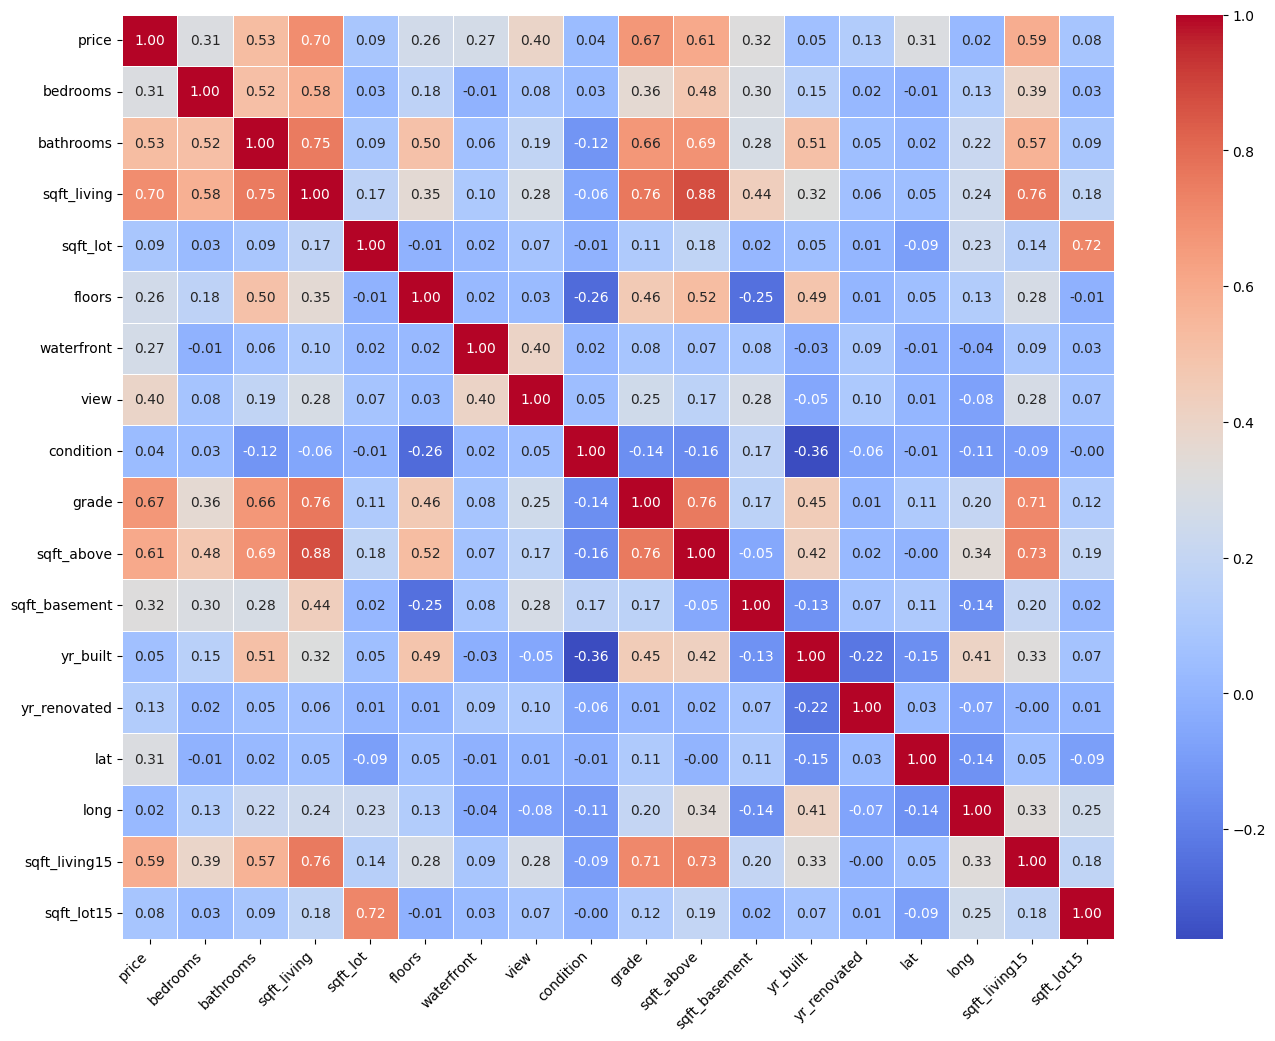

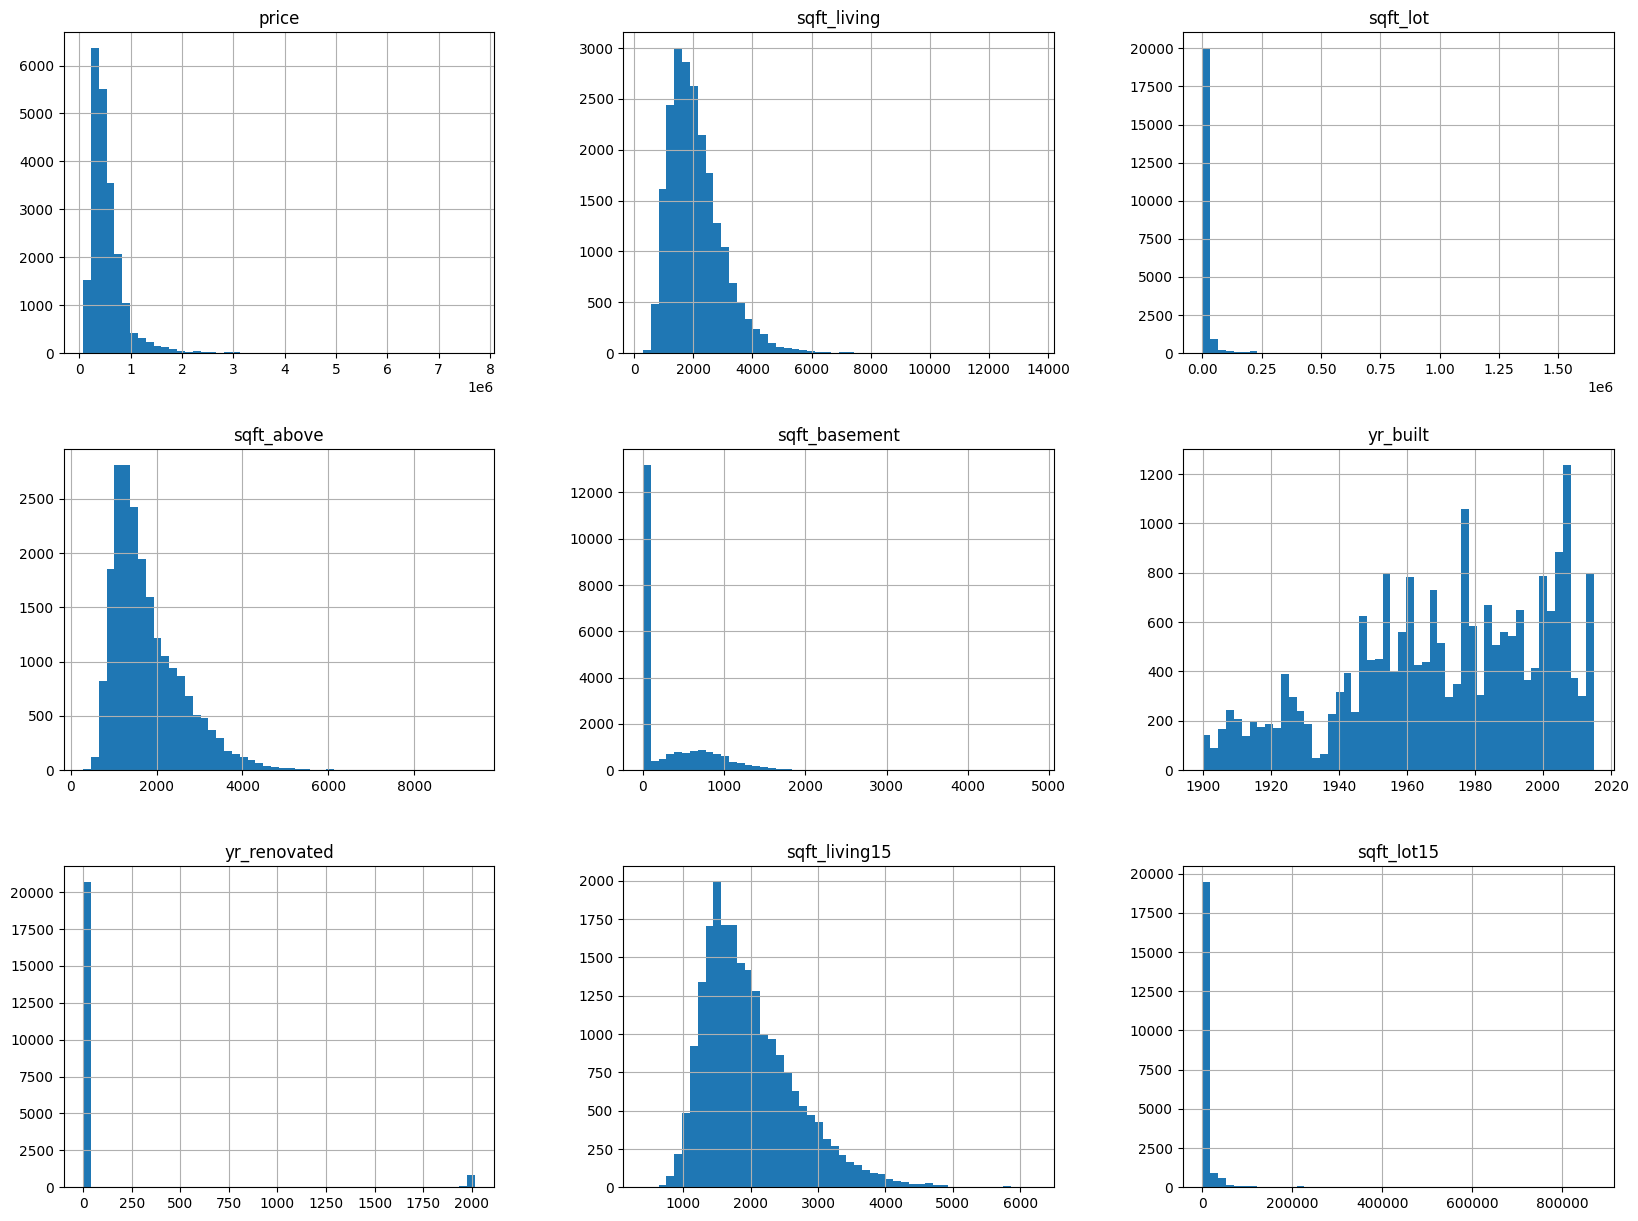

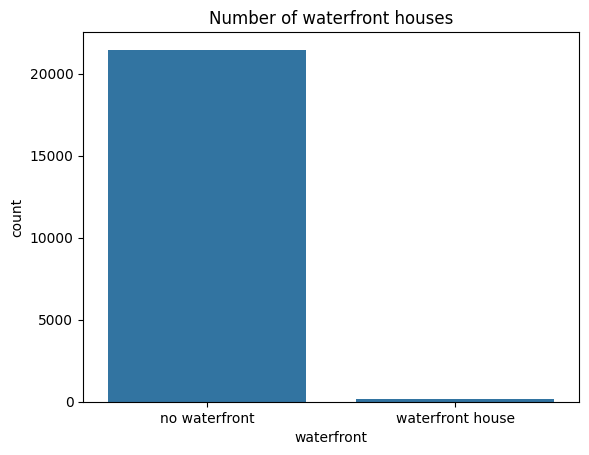

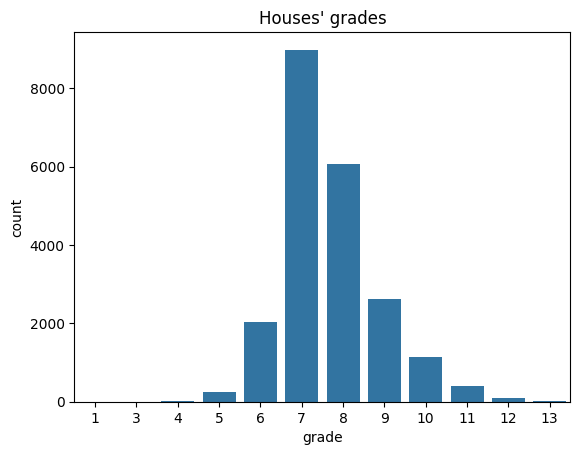

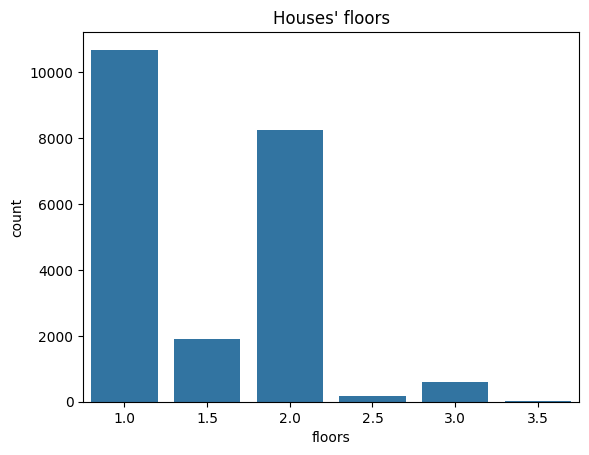

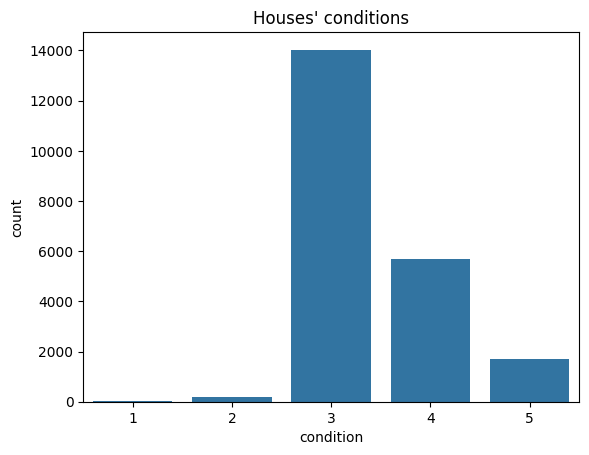

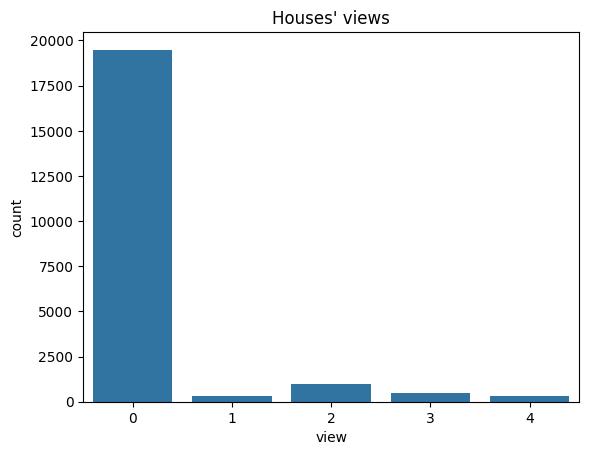

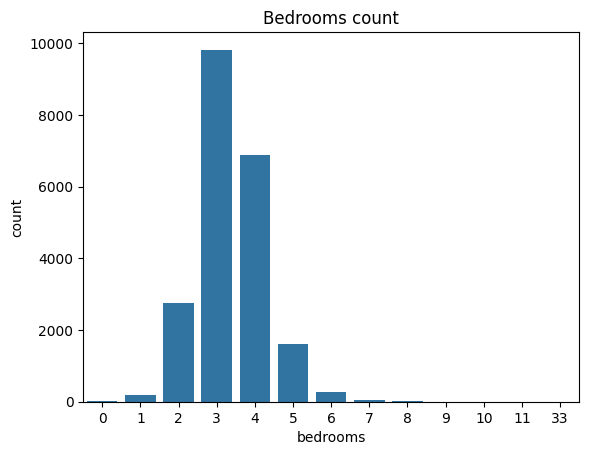

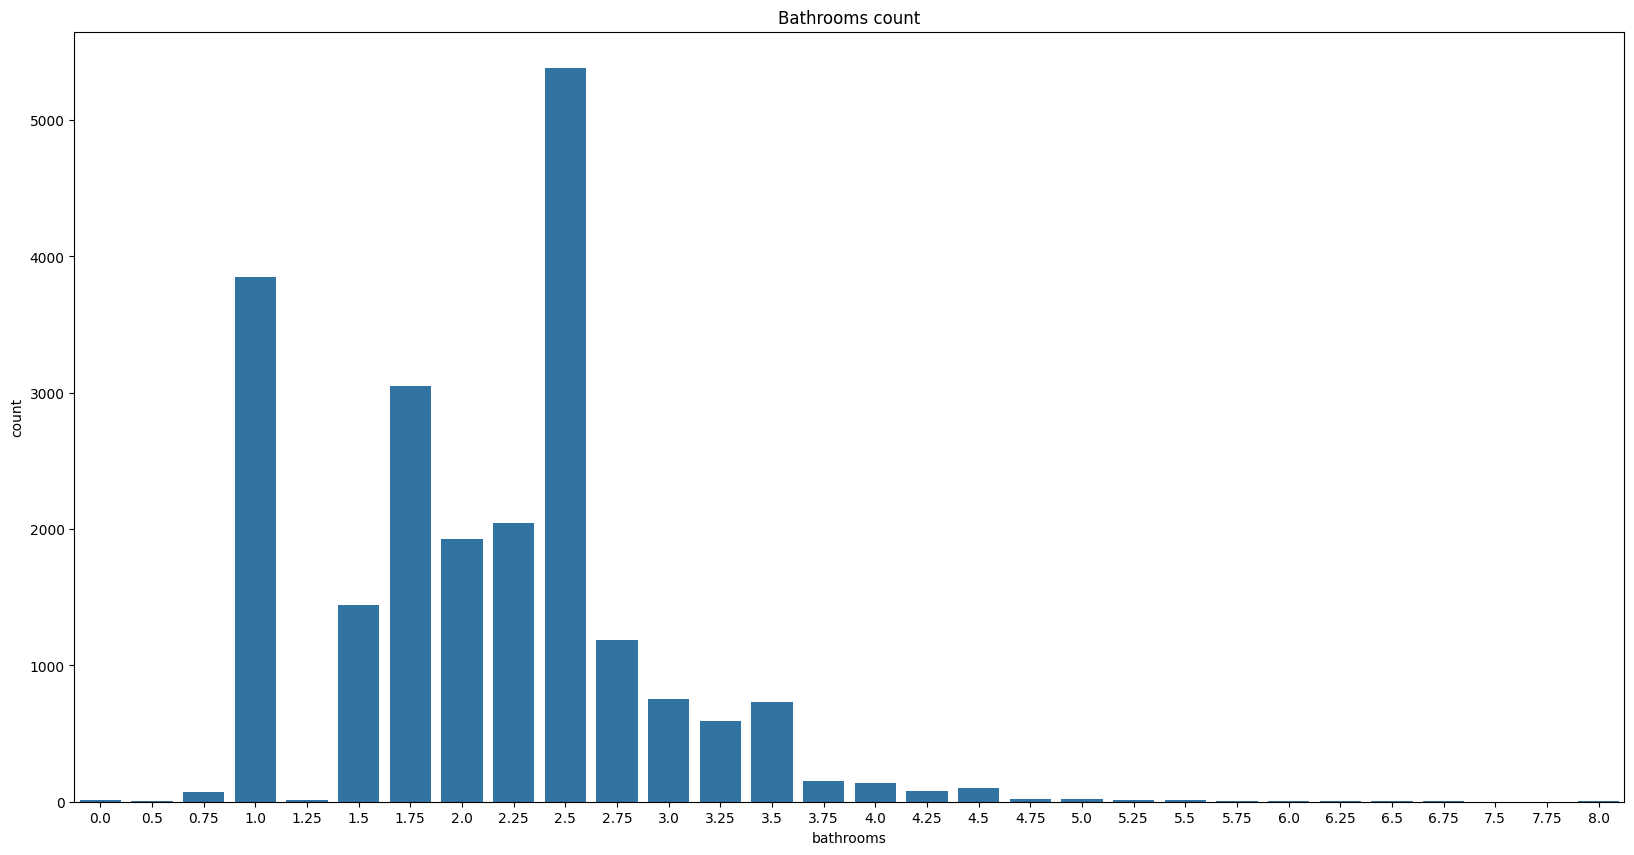

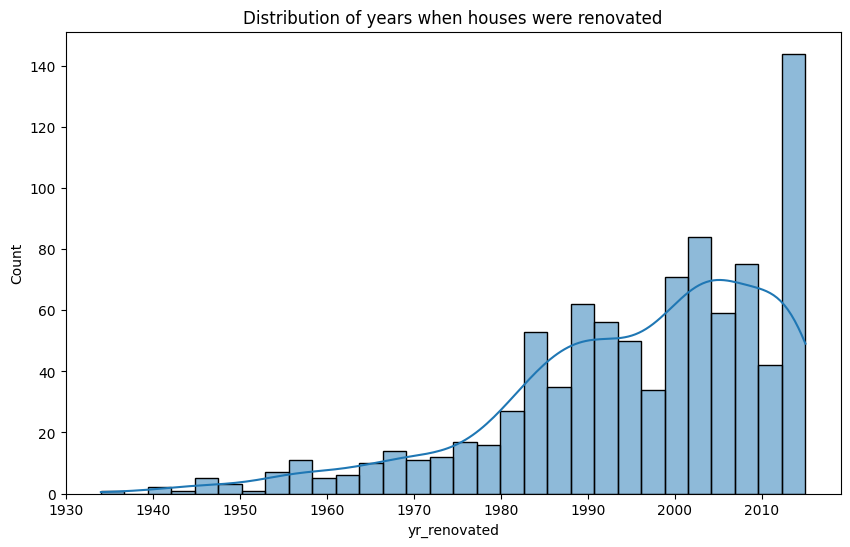

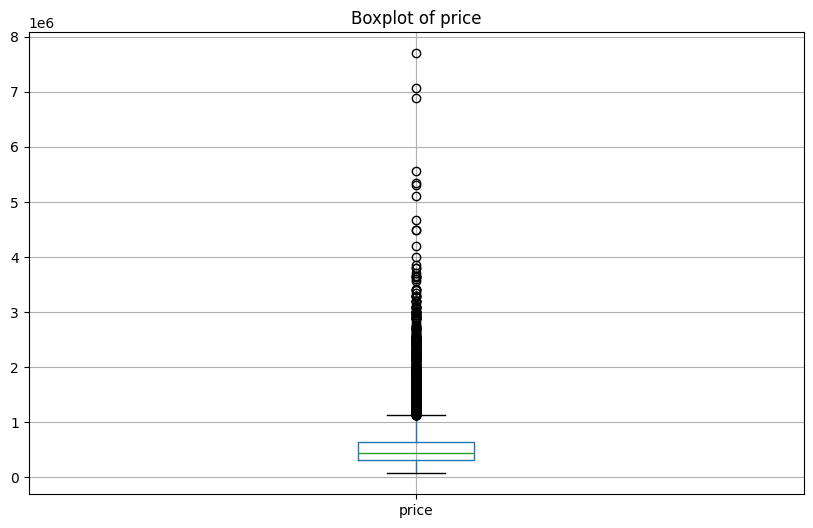

In [ ]:
visual_exploration_code_writer = student_a

def generate_plots(df: pd.DataFrame) -> None:
    #correlation heatmap
    columns_to_not_be_included = ['id', 'date', 'zipcode']
    plt.figure(figsize=(16, 12)) 

    corr_matrix = df.drop(columns=columns_to_not_be_included).corr(numeric_only=True)

    sns.heatmap(
        corr_matrix,
        annot=True,
        fmt='.2f',
        cmap='coolwarm',
        linewidths=0.5,
        annot_kws={'size': 10}
    )


    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)

    plt.show()

    #histograms
    columns_to_not_be_included = ['id', 'date', 'zipcode', 'lat', 'long', 'waterfront', 'grade', 'floors', 'condition', 'view', 'bedrooms', 'bathrooms']
    df.drop(columns=columns_to_not_be_included).hist(bins=50, figsize=(20, 15))
    plt.show()

    #waterfront houses
    sns.countplot(x=df['waterfront'])
    plt.title('Number of waterfront houses')
    plt.xticks([0, 1], ['no waterfront', 'waterfront house'])
    plt.show()

    #grade
    sns.countplot(x=df['grade'])
    plt.title("Houses' grades")
    plt.show()

    #floors
    sns.countplot(x=df['floors'])
    plt.title("Houses' floors")
    plt.show()

    #condition
    sns.countplot(x=df['condition'])
    plt.title("Houses' conditions")
    plt.show()

    #view
    sns.countplot(x=df['view'])
    plt.title("Houses' views")
    plt.show()

    #bedrooms
    sns.countplot(x=df['bedrooms'])
    plt.title('Bedrooms count')
    plt.show()

    #bathrooms
    plt.figure(figsize=(20, 10))
    sns.countplot(x=df['bathrooms'])
    plt.title('Bathrooms count')
    plt.show()

    #yr_renovated
    renovated = df[df['yr_renovated'] != 0]
    plt.figure(figsize=(10, 6))
    sns.histplot(renovated['yr_renovated'], bins=30, kde=True)
    plt.title('Distribution of years when houses were renovated')
    plt.show()

    #price
    cols = ['price']

    plt.figure(figsize=(10, 6))
    df[cols].boxplot()
    plt.title('Boxplot of price')
    plt.show()


start_time_vis = now()
generate_plots(data)
end_time_vis = now()


visual_observations = """
1. Correlation heatmap: We observe that bathrooms, sqft_living, grade, sqft_above, and sqft_living15 are highly correlated with the price column. The view column shows a mild correlation with price.

2. Price histogram: The distribution is right-skewed.

3. Sqft_living histogram: The distribution is right-skewed.

4. Sqft_lot histogram: The distribution is right-skewed.

5. Sqft_above histogram: The distribution is right-skewed.

6. Sqft_basement histogram: The distribution is right-skewed.

7. yr_built histogram: The data is fairly evenly distributed, with a slight increase in houses built recently.

8. yr_renovated histogram: The distribution is highly imbalanced because unrenovated houses are encoded as 0.

9. sqft_living15 histogram: The distribution is right-skewed.

10. sqft_lot15 histogram: The distribution is right-skewed.

11. Number of waterfront houses - bar plot: The class balance is highly skewed towards non-waterfront houses.

12. House grades - bar plot: The distribution resembles a normal distribution, but is slightly skewed towards grades higher than the average.

13. House floors - bar plot: The largest groups are houses with 1 or 2 floors; the smallest group consists of houses with 3.5 floors.

14. House conditions - bar plot: The majority of houses have a condition rating of 3. The smallest group consists of houses with a condition of 1.

15. House views - bar plot: The vast majority of houses have no view.

16. Bedrooms count - bar plot: The most common houses have 3 bedrooms. Notably, there is a suspicious outlier with 33 bedrooms, which we will investigate later.

17. Bathrooms count - bar plot: We observed records with 0 or 0.5 bathrooms, which appears anomalous. We will investigate this further.
"""

transformation_decision_comment = """
Based on the plots we have decided that we are going to:
- log-scale: price, sqft_living, sqft_lot, sqft_above, sqft_basement, sqft_living15, sqft_lot15
- standard scale: every numerical column (including the log-scaled ones, excluding target
- new column creation for yr_renovated: we are deciding to change this column into years since renovation
- new column creation for yr_built: we are deciding to change this column into age
- One-hot encoding: ZIP code
"""

#############################################
# Documentation
#############################################
# There are three steps involved in this process:
# 1. activity creates a figure, report etc. => in this case a report
# 2. activity inspects the outcome and derives decisions => in this case to remove the outliers that were found
# 3. activity follows up on the decision by changing the data => will be done in the data preparation phase

# 1. Activty: Checking for outliers and creating the report
vis_uuid_executor = "3e1b715a-ba8c-4e7a-a871-bacb709ce4b1"
vis_uuid_writer = "dde34fb7-f980-45a0-b429-ebe70180db14"
engine.insert([
    f':visual_exploration prov:qualifiedAssociation :{vis_uuid_executor} .',
    f':{vis_uuid_executor} prov:agent :{executed_by} .',
    f':{vis_uuid_executor} rdf:type prov:Association .',
    f':{vis_uuid_executor} prov:hadRole :{code_executor_role} .',
], prefixes=prefixes)

visual_activity = [
    ':visual_exploration rdf:type prov:Activity .',
    ':visual_exploration sc:isPartOf :data_understanding_phase .',
    ':visual_exploration rdfs:label "Visual Data Exploration" .',
    
    f':visual_exploration prov:startedAtTime "{start_time_vis}"^^xsd:dateTime .',
    f':visual_exploration prov:endedAtTime "{end_time_vis}"^^xsd:dateTime .',
    
    f':visual_exploration prov:qualifiedAssociation :{vis_uuid_writer} .',
    f':{vis_uuid_writer} prov:agent :{visual_exploration_code_writer} .',
    f':{vis_uuid_writer} rdf:type prov:Association .',
    f':{vis_uuid_writer} prov:hadRole :{code_writer_role} .',

    ':visual_exploration prov:used :data .',
    
    ':visual_findings rdf:type prov:Entity .',
    ':visual_findings rdfs:label "Visual Analysis Observations" .',
    
    f':visual_findings rdfs:comment """{visual_observations}""" .',
    
    ':visual_findings prov:wasGeneratedBy :visual_exploration .',
    ':visual_findings prov:wasDerivedFrom :data .',


    ':transformation_decisions rdf:type prov:Entity .',
    ':transformation_decisions rdfs:label "Columns transformation decisions" .',
    f':transformation_decisions rdfs:comment """{transformation_decision_comment}""" .',
    ':transformation_decisions prov:wasGeneratedBy :visual_exploration .',
    ':transformation_decisions prov:wasDerivedFrom :visual_findings .',

]
engine.insert(visual_activity, prefixes=prefixes)

### Outliers checking


In [ ]:
check_outliers_code_writer = student_a

def check_if_id_is_unique(df: pd.DataFrame) -> pd.DataFrame:
    return df[df.duplicated(subset='id', keep=False)].sort_values(by='id')

def check_bedrooms_outlier(df: pd.DataFrame) -> pd.DataFrame:
    return df[(df['bedrooms'] == 33) | (df['bedrooms'] == 0)]

def check_bathrooms_outlier(df: pd.DataFrame) -> pd.DataFrame:
    return df[(df['bathrooms'] == 0) | (df['bathrooms'] == 0.5)]

def check_price_outliers(df: pd.DataFrame) -> pd.DataFrame:
    return df[df['price'] > 5000000]

def run_exploration(df: pd.DataFrame):
    
    
    duplicates = check_if_id_is_unique(df)
    bed_out = check_bedrooms_outlier(df)
    bath_out = check_bathrooms_outlier(df)
    price_out = check_price_outliers(df)
    
    findings = {
        "visual_check": "Plots generated. Extreme values observed.",
        
        "duplicates_found": {
            "count": len(duplicates),
            "records": duplicates.to_dict(orient='records')
        },
        
        "bedrooms_outliers": {
            "count": len(bed_out),
            "records": bed_out.to_dict(orient='records')
        },
        
        "bathrooms_outliers": {
            "count": len(bath_out),
            "records": bath_out.to_dict(orient='records')
        },
        
        "high_price_examples": {
            "count": len(price_out),
            "top_price_records": price_out.sort_values('price', ascending=False).to_dict(orient='records')
        }
    }
    
    return findings

start_time_inv = now()
investigation_report = run_exploration(data)
end_time_inv = now()
print(investigation_report)
print(json.dumps(investigation_report, indent=2, default=str))

inv_uuid_executor = "6691f08e-a030-4a18-b496-576e473ea899"
inv_uuid_writer = "2b9d7804-4baf-493d-81d9-2380aa1b7841"

engine.insert([
    f':targeted_investigation prov:qualifiedAssociation :{inv_uuid_executor} .',
    f':{inv_uuid_executor} prov:agent :{executed_by} .',
    f':{inv_uuid_executor} rdf:type prov:Association .',
    f':{inv_uuid_executor} prov:hadRole :{code_executor_role} .',
], prefixes=prefixes)

investigation_activity = [
    ':targeted_investigation rdf:type prov:Activity .',
    ':targeted_investigation sc:isPartOf :data_understanding_phase .',
    ':targeted_investigation rdfs:label "Targeted Anomaly Investigation" .',
    f':targeted_investigation rdfs:comment "Executed code to identify specific IDs for anomalies observed in visual step." .',
    
    f':targeted_investigation prov:startedAtTime "{start_time_inv}"^^xsd:dateTime .',
    f':targeted_investigation prov:endedAtTime "{end_time_inv}"^^xsd:dateTime .',

    f':targeted_investigation prov:qualifiedAssociation :{inv_uuid_writer} .',
    f':{inv_uuid_writer} prov:agent :{check_outliers_code_writer} .',
    f':{inv_uuid_writer} rdf:type prov:Association .',
    f':{inv_uuid_writer} prov:hadRole :{code_writer_role} .',

    ':targeted_investigation prov:used :visual_findings .',
    ':targeted_investigation prov:used :data .',
    
    ':anomaly_report rdf:type prov:Entity .',
    ':anomaly_report rdfs:label "Anomaly Investigation Report" .',
    f':anomaly_report rdfs:comment """{json.dumps(investigation_report, indent=2, default=str)}""" .',
    ':anomaly_report prov:wasGeneratedBy :targeted_investigation .',
]
engine.insert(investigation_activity, prefixes=prefixes)

{'visual_check': 'Plots generated. Extreme values observed.', 'duplicates_found': {'count': 353, 'records': [{'id': 1000102, 'date': Timestamp('2015-04-22 00:00:00'), 'price': 300000.0, 'bedrooms': 6, 'bathrooms': 3.0, 'sqft_living': 2400, 'sqft_lot': 9373, 'floors': 2.0, 'waterfront': 0, 'view': 0, 'condition': 3, 'grade': 7, 'sqft_above': 2400, 'sqft_basement': 0, 'yr_built': 1991, 'yr_renovated': 0, 'zipcode': 98002, 'lat': 47.3262, 'long': -122.214, 'sqft_living15': 2060, 'sqft_lot15': 7316}, {'id': 1000102, 'date': Timestamp('2014-09-16 00:00:00'), 'price': 280000.0, 'bedrooms': 6, 'bathrooms': 3.0, 'sqft_living': 2400, 'sqft_lot': 9373, 'floors': 2.0, 'waterfront': 0, 'view': 0, 'condition': 3, 'grade': 7, 'sqft_above': 2400, 'sqft_basement': 0, 'yr_built': 1991, 'yr_renovated': 0, 'zipcode': 98002, 'lat': 47.3262, 'long': -122.214, 'sqft_living15': 2060, 'sqft_lot15': 7316}, {'id': 7200179, 'date': Timestamp('2014-10-16 00:00:00'), 'price': 150000.0, 'bedrooms': 2, 'bathrooms': 

### Decisions regarding the outliers

In [ ]:
dec_writer = student_a
decision_text = """
Decision Strategy based on Anomaly Report:
1. Bedrooms: we are deciding to remove the record with 33 bathrooms as it seems impossible especially taking into consideration the size of the house
2. Bathrooms: we are deciding to remove the records with 0 or 0.5 bathrooms
3. Duplicates: we are keeping the records with duplicated id as we believe that they contain valuable information
4. High Price: properties with high prices seems correct. The high prices results from the fact that they are mansions
"""

dec_uuid_executor = "192af1e6-8c6e-48fa-bae1-f343f6e89d36"
dec_uuid_writer = "3300a85d-45e9-4dcc-a970-c445f78001e6"

engine.insert([
    f':decide_cleaning prov:qualifiedAssociation :{dec_uuid_executor} .',
    f':{dec_uuid_executor} prov:agent :{executed_by} .',
    f':{dec_uuid_executor} rdf:type prov:Association .',
    f':{dec_uuid_executor} prov:hadRole :{code_executor_role} .',
], prefixes=prefixes)

engine.insert([
    f':decide_cleaning prov:qualifiedAssociation :{dec_uuid_writer} .',
    f':{dec_uuid_writer} prov:agent :{dec_writer} .',
    f':{dec_uuid_writer} rdf:type prov:Association .',
    f':{dec_uuid_writer} prov:hadRole :{code_writer_role} .',
], prefixes=prefixes)

decision_activity = [
    ':decide_cleaning rdf:type prov:Activity .',
    ':decide_cleaning sc:isPartOf :data_understanding_phase .',
    ':decide_cleaning rdfs:label "Decision on Data Cleaning" .',
    f':decide_cleaning rdfs:comment "Manual review of the outliers and decision whether to keep them." .',
    
    
    f':decide_cleaning prov:qualifiedAssociation :{dec_uuid_writer} .',
    
    ':decide_cleaning prov:used :anomaly_report .',
    
    ':outliers_decision rdf:type prov:Entity .',
    ':outliers_decision rdfs:label "Final Cleaning Strategy" .',
    f':outliers_decision rdfs:comment """{decision_text}""" .',
    ':outliers_decision prov:wasGeneratedBy :decide_cleaning .',
]
engine.insert(decision_activity, prefixes=prefixes)

### Statistical properties

In [75]:
stats_code_writer = student_a
def calculate_descriptive_stats(df: pd.DataFrame) -> dict:
    def iqr(x):
        return x.quantile(0.75) - x.quantile(0.25)
    
    aggregations = ['mean', 'median', 'std', 'min', 'max', iqr]

    cols_to_drop = ['id', 'date', 'zipcode', 'waterfront', 'yr_built', 'yr_renovated', 'lat', 'long']
    df_stat_prop = df.drop(columns=cols_to_drop, errors='ignore')
    
    statistical_properties = df_stat_prop.agg(aggregations).T

    statistical_properties.rename(columns={
        'mean': 'Mean',
        'std': 'Standard deviation',
        'min': 'Minimal value',
        'max': 'Maximal value',
        'iqr': 'IQR',
        'median': 'Median'
    }, inplace=True)
    
    return statistical_properties.round(2).to_dict()

start_time_stat = now()
stats_results = calculate_descriptive_stats(data)
end_time_stat = now()

print(pd.DataFrame(stats_results).T)

                         price  bedrooms  bathrooms  sqft_living    sqft_lot  \
Mean                 540088.14      3.37       2.11      2079.90    15106.97   
Median               450000.00      3.00       2.25      1910.00     7618.00   
Standard deviation   367127.20      0.93       0.77       918.44    41420.51   
Minimal value         75000.00      0.00       0.00       290.00      520.00   
Maximal value       7700000.00     33.00       8.00     13540.00  1651359.00   
IQR                  323050.00      1.00       0.75      1123.00     5648.00   

                    floors  view  condition  grade  sqft_above  sqft_basement  \
Mean                  1.49  0.23       3.41   7.66     1788.39         291.51   
Median                1.50  0.00       3.00   7.00     1560.00           0.00   
Standard deviation    0.54  0.77       0.65   1.18      828.09         442.58   
Minimal value         1.00  0.00       1.00   1.00      290.00           0.00   
Maximal value         3.50  4.00  

In [ ]:
stat_analysis_text = """
Statistical Analysis Findings:

1. Price distribution:
   - The distribution is right-skewed: Mean ($540k) is significantly higher than the Median ($450k).
   - High variation: Standard deviation is large (~$367k), driven by luxury properties (Max price $7.7M).

2. Data anomalies:
   - Bedrooms: The maximum value of 33 confirms the outlier detected visually. Minimum of 0 is suspicious.
   - Bathrooms: Minimum value of 0 indicates uninhabitable properties or data errors.

3. Property Size:
   - Living Area: Huge disparity between smallest (290 sqft) and largest (13,540 sqft) homes.
   - Lot Size: Extremely high standard deviation relative to the mean suggests a mix of small city plots and large rural estates.
"""
stat_uuid_executor = "69d70d9a-c616-43f0-873c-d79b7c0b9e93"
stat_uuid_writer = "9cea7894-889b-4479-8f86-e32e27c32431"

engine.insert([
    f':calculate_statistics prov:qualifiedAssociation :{stat_uuid_executor} .',
    f':{stat_uuid_executor} prov:agent :{executed_by} .',
    f':{stat_uuid_executor} rdf:type prov:Association .',
    f':{stat_uuid_executor} prov:hadRole :{code_executor_role} .',
], prefixes=prefixes)

stats_activity = [
    ':calculate_statistics rdf:type prov:Activity .',
    ':calculate_statistics sc:isPartOf :data_understanding_phase .',
    ':calculate_statistics rdfs:label "Descriptive Statistics Calculation" .',
    f':calculate_statistics rdfs:comment "Calculated mean, median, std, min, max, and IQR for numerical features." .',
    
    f':calculate_statistics prov:startedAtTime "{start_time_stat}"^^xsd:dateTime .',
    f':calculate_statistics prov:endedAtTime "{end_time_stat}"^^xsd:dateTime .',
    
    f':calculate_statistics prov:qualifiedAssociation :{stat_uuid_writer} .',
    f':{stat_uuid_writer} prov:agent :{stats_code_writer} .',
    f':{stat_uuid_writer} rdf:type prov:Association .',
    f':{stat_uuid_writer} prov:hadRole :{code_writer_role} .',

    ':calculate_statistics prov:used :data .',

    ':statistical_report rdf:type prov:Entity .',
    ':statistical_report rdfs:label "Descriptive Statistics Table" .',

    f':statistical_report rdfs:comment """{json.dumps(stats_results)}""" .',
    
    ':statistical_report prov:wasGeneratedBy :calculate_statistics .',
    ':statistical_report prov:wasDerivedFrom :data .',



    ':statistical_insights rdf:type prov:Entity .',
    ':statistical_insights rdfs:label "Statistical Analysis Conclusions" .',
    f':statistical_insights rdfs:comment """{stat_analysis_text}""" .',
    ':statistical_insights prov:wasGeneratedBy :calculate_statistics .',
    ':statistical_insights prov:wasDerivedFrom :statistical_report .',
]
engine.insert(stats_activity, prefixes=prefixes)

### Potential risks and additional types of bias

In [ ]:
pot_risks_and_bias_writer = student_a

pot_risks_and_bias_uuid_writer = "4b681b10-3092-41c7-9c85-00793ab87f30"


engine.insert([
    f':identifying_potential_risks_and_bias prov:qualifiedAssociation :{pot_risks_and_bias_uuid_writer} .',
    f':{pot_risks_and_bias_uuid_writer} prov:agent :{pot_risks_and_bias_writer} .',
    f':{pot_risks_and_bias_uuid_writer} rdf:type prov:Association .',
    f':{pot_risks_and_bias_uuid_writer} prov:hadRole :{code_writer_role} .',
], prefixes=prefixes)

comment_text = """
- data comes only from the period from May 2014 to May 2015 which makes it difficult to capture the inflation and other properties that change over time
- we are not sure what counts as renovation, therefore it is possible that smaller renovations (bathroom renovation for example) might not be reflected in the dataset
- variables grade and condition are assigned subjectively by the different people which introduces bias
"""
decision_activity = [
    ':identifying_potential_risks_and_bias rdf:type prov:Activity .',
    ':identifying_potential_risks_and_bias sc:isPartOf :data_understanding_phase .',
    ':identifying_potential_risks_and_bias rdfs:label "Identifying potential risks and bias" .',
    f':identifying_potential_risks_and_bias rdfs:comment  """{comment_text}""" .',
]
engine.insert(decision_activity, prefixes=prefixes)

## Data Preparation

In [ ]:
## Each Activity that follows is part of the Data Preparation Phase

data_preparation_phase_executor = [
f':data_preparation_phase rdf:type prov:Activity .',
f':data_preparation_phase rdfs:label "Data Preparation Phase" .', 
]
engine.insert(data_preparation_phase_executor, prefixes=prefixes)

In [ ]:
handle_outliers_code_writer = student_b
def handle_outliers(df: pd.DataFrame) -> pd.DataFrame:
    # Remove specific bedroom outliers
    df = df[~df['bedrooms'].isin([0, 33])]
    
    # Remove specific bathroom outliers
    df = df[~df['bathrooms'].isin([0, 0.5])]
    
    return df

start_time_td = now()
data = handle_outliers(data)
end_time_td = now()

#############################################
# Documentation
#############################################

ro_ass_uuid_executor = "1d30f7a5-5feb-46ea-b30a-64370c34a29e"
handle_outliers_executor = [
    f':handle_outliers prov:qualifiedAssociation :{ro_ass_uuid_executor} .',
    f':{ro_ass_uuid_executor} prov:agent :{executed_by} .',
    f':{ro_ass_uuid_executor} rdf:type prov:Association .',
    f':{ro_ass_uuid_executor} prov:hadRole :{code_executor_role} .',
]
engine.insert(handle_outliers_executor, prefixes=prefixes)

td_ass_uuid_writer = "faec6534-a3d9-4105-8871-d3643e21f825"
td_comment = """
Removing all outliers that were identified in the Data Understanding Phase and were decided to be removed (mainly bedrooms and bathrooms).
"""
handle_outliers_activity = [
    ':handle_outliers rdf:type prov:Activity .',
    ':handle_outliers sc:isPartOf :data_preparation_phase .',
    ':handle_outliers rdfs:label "Outlier Removal" .',
    f':handle_outliers rdfs:comment """{td_comment}""" .', 
    f':handle_outliers prov:startedAtTime "{start_time_td}"^^xsd:dateTime .',
    f':handle_outliers prov:endedAtTime "{end_time_td}"^^xsd:dateTime .',
    f':handle_outliers prov:qualifiedAssociation :{td_ass_uuid_writer} .',
    f':{td_ass_uuid_writer} prov:agent :{handle_outliers_code_writer} .',
    f':{td_ass_uuid_writer} rdf:type prov:Association .',
    f':{td_ass_uuid_writer} prov:hadRole :{code_writer_role} .',
    ':handle_outliers prov:used :data .',
    ':handle_outliers prov:used :outliers_decision .',
    ':data_no_outliers rdf:type prov:Entity .',
    ':data_no_outliers prov:wasGeneratedBy :handle_outliers .',
    ':data_no_outliers prov:wasDerivedFrom :data .',
]
engine.insert(handle_outliers_activity, prefixes=prefixes)

**Continue with other tasks of the Data Preparation phase such as binning, scaling etc...**

In [ ]:
one_hot_encode_code_writer = student_b
def one_hot_encode_data(df: pd.DataFrame) -> pd.DataFrame:
    df['zipcode'] = df['zipcode'].astype(str)
    # One-Hot Encoding
    df = pd.get_dummies(df, columns=['zipcode'], prefix='zip')

    return df

start_time_td = now()
data = one_hot_encode_data(data)
end_time_td = now()

#############################################
# Documentation
#############################################

ro_ass_uuid_executor = "68e1b3a7-8d69-4edd-91cd-57123b836fd8"
one_hot_encode_data_executor = [
    f':one_hot_encode_data prov:qualifiedAssociation :{ro_ass_uuid_executor} .',
    f':{ro_ass_uuid_executor} prov:agent :{executed_by} .',
    f':{ro_ass_uuid_executor} rdf:type prov:Association .',
    f':{ro_ass_uuid_executor} prov:hadRole :{code_executor_role} .',
]
engine.insert(one_hot_encode_data_executor, prefixes=prefixes)

td_ass_uuid_writer = "1de22553-f162-4096-af50-d993139b08e8"
td_comment = """
One hot encoding for the zip variable, which looks like numerical but is not.
"""
data_scaling_activity = [
    ':one_hot_encode_data rdf:type prov:Activity .',
    ':one_hot_encode_data sc:isPartOf :data_preparation_phase .',
    ':one_hot_encode_data rdfs:label "One-Hot Encoding" .',
    f':one_hot_encode_data rdfs:comment """{td_comment}""" .', 
    f':one_hot_encode_data prov:startedAtTime "{start_time_td}"^^xsd:dateTime .',
    f':one_hot_encode_data prov:endedAtTime "{end_time_td}"^^xsd:dateTime .',
    f':one_hot_encode_data prov:qualifiedAssociation :{td_ass_uuid_writer} .',
    f':{td_ass_uuid_writer} prov:agent :{one_hot_encode_code_writer} .',
    f':{td_ass_uuid_writer} rdf:type prov:Association .',
    f':{td_ass_uuid_writer} prov:hadRole :{code_writer_role} .',
    ':one_hot_encode_data prov:used :data .',
    ':one_hot_encode_data prov:used :transformation_decisions .',
    ':encoded_data rdf:type prov:Entity .',
    ':encoded_data prov:wasGeneratedBy :one_hot_encode_data .',
    ':encoded_data prov:wasDerivedFrom :data_no_outliers .',
]
engine.insert(data_scaling_activity, prefixes=prefixes)

In [ ]:
years_to_age_code_writer = student_b
def transform_years_column_to_age(df: pd.DataFrame) -> pd.DataFrame:
    df['sale_year'] = df['date'].dt.year
    df['sale_month'] = df['date'].dt.month
    df['house_age'] = df['sale_year'] - df['yr_built']
    df['last_update'] = df.apply(
            lambda row: row['yr_renovated'] if row['yr_renovated'] > 0 else row['yr_built'], 
            axis=1
        )
    df['years_since_renovation'] = df['sale_year'] - df['last_update']
    
    # also remove id as it gives us nothing for the model
    drop_cols = ['id', 'date', 'yr_built', 'yr_renovated', 'last_update']
    df.drop(columns=[c for c in drop_cols if c in df.columns], inplace=True)
        
    return df

start_time_td = now()
data = transform_years_column_to_age(data)
end_time_td = now()

#############################################
# Documentation
#############################################

ro_ass_uuid_executor = "85a48ba4-8c66-4960-8d3f-0d864d86f852"
transform_years_column_to_age_executor = [
    f':transform_years_column_to_age prov:qualifiedAssociation :{ro_ass_uuid_executor} .',
    f':{ro_ass_uuid_executor} prov:agent :{executed_by} .',
    f':{ro_ass_uuid_executor} rdf:type prov:Association .',
    f':{ro_ass_uuid_executor} prov:hadRole :{code_executor_role} .',
]
engine.insert(transform_years_column_to_age_executor, prefixes=prefixes)

td_ass_uuid_writer = "efdddff4-30cc-4c45-91b8-22e8649ef5f8"
td_comment = """
Transforming the year of building and renovation into continuous variables age that are much better distributed for the models.
Removed id column as it is useless in modelling. Added sale year and month as new attributes.
"""
transform_years_column_to_age_activity = [
    ':transform_years_column_to_age rdf:type prov:Activity .',
    ':transform_years_column_to_age sc:isPartOf :data_preparation_phase .',
    ':transform_years_column_to_age rdfs:label "Feature Engineering" .',
    f':transform_years_column_to_age rdfs:comment """{td_comment}""" .', 
    f':transform_years_column_to_age prov:startedAtTime "{start_time_td}"^^xsd:dateTime .',
    f':transform_years_column_to_age prov:endedAtTime "{end_time_td}"^^xsd:dateTime .',
    f':transform_years_column_to_age prov:qualifiedAssociation :{td_ass_uuid_writer} .',
    f':{td_ass_uuid_writer} prov:agent :{years_to_age_code_writer} .',
    f':{td_ass_uuid_writer} rdf:type prov:Association .',
    f':{td_ass_uuid_writer} prov:hadRole :{code_writer_role} .',
    ':transform_years_column_to_age prov:used :data .',
    ':transform_years_column_to_age prov:used :transformation_decisions .',
    ':data_enriched rdf:type prov:Entity .',
    ':data_enriched prov:wasGeneratedBy :transform_years_column_to_age .',
    ':data_enriched prov:wasDerivedFrom :scaled_data .',
]
engine.insert(transform_years_column_to_age_activity, prefixes=prefixes)

In [ ]:
data_scaling_code_writer = student_b
def scale_data(df: pd.DataFrame) -> pd.DataFrame:
    def log_scale_columns(df: pd.DataFrame) -> pd.DataFrame:
        cols_to_log = ['price', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_living15', 'sqft_lot15', 'sqft_basement']

        for col in cols_to_log:
            if col in df.columns:
                df[col] = np.log1p(df[col])
        
        return df

    def standard_scale_columns(df: pd.DataFrame) -> pd.DataFrame:
        target_col = 'price'
        exclude_cols = [target_col, 'sale_year', 'sale_month']
        # Identify numerical columns (exclude boolean/dummies)
        bool_cols = [c for c in df.columns if c.startswith('zip_')]
        num_cols = [c for c in df.columns if 
                    c not in bool_cols 
                    and c not in exclude_cols
                    and c ]

        scaler = StandardScaler()
        df[num_cols] = scaler.fit_transform(df[num_cols])

        return df

    df = log_scale_columns(df)
    df = standard_scale_columns(df)
    return df

start_time_td = now()
data = scale_data(data)
end_time_td = now()

#############################################
# Documentation
#############################################

ro_ass_uuid_executor = "31e7f906-269d-4805-9cf6-f68d8899d709"
data_scaling_executor = [
    f':data_scaling prov:qualifiedAssociation :{ro_ass_uuid_executor} .',
    f':{ro_ass_uuid_executor} prov:agent :{executed_by} .',
    f':{ro_ass_uuid_executor} rdf:type prov:Association .',
    f':{ro_ass_uuid_executor} prov:hadRole :{code_executor_role} .',
]
engine.insert(data_scaling_executor, prefixes=prefixes)

td_ass_uuid_writer = "f689f70a-b41d-4614-8a55-11efff39f53c"
td_comment = """
Standard scaling for all numerical columns (excluding target) and log-scaling of all the skewed columns that were identified in the Data Understanding Phase.
"""
data_scaling_activity = [
    ':data_scaling rdf:type prov:Activity .',
    ':data_scaling sc:isPartOf :data_preparation_phase .',
    ':data_scaling rdfs:label "Data Scaling" .',
    f':data_scaling rdfs:comment """{td_comment}""" .', 
    f':data_scaling prov:startedAtTime "{start_time_td}"^^xsd:dateTime .',
    f':data_scaling prov:endedAtTime "{end_time_td}"^^xsd:dateTime .',
    f':data_scaling prov:qualifiedAssociation :{td_ass_uuid_writer} .',
    f':{td_ass_uuid_writer} prov:agent :{data_scaling_code_writer} .',
    f':{td_ass_uuid_writer} rdf:type prov:Association .',
    f':{td_ass_uuid_writer} prov:hadRole :{code_writer_role} .',
    ':data_scaling prov:used :data .',
    ':data_scaling prov:used :transformation_decisions .',
    ':scaled_data rdf:type prov:Entity .',
    ':scaled_data prov:wasGeneratedBy :data_scaling .',
    ':scaled_data prov:wasDerivedFrom :encoded_data .',
]
engine.insert(data_scaling_activity, prefixes=prefixes)

In [ ]:
# Your final transformed dataset should also be documented appropriately using Croissant, SI, etc.

prepared_data_triples = [
    ':prepared_data rdf:type prov:Entity .',
    ':prepared_data prov:wasDerivedFrom :data_enriched .',
    ':prepared_data rdf:type sc:Dataset .',
    ':prepared_recordset rdf:type cr:RecordSet .',
    ':prepared_data cr:recordSet :prepared_recordset .',
    ':prepared_recordset sc:name "Prepared Data Schema" .',
    ':prepared_recordset sc:description "Final dataset with log-transforms, one-hot encoding, and feature engineering applied." .',

    # old fields, only standard scaled if numerical
    ':prepared_recordset cr:field :field_bedrooms .',
    ':prepared_recordset cr:field :field_bathrooms .',
    ':prepared_recordset cr:field :field_floors .',
    ':prepared_recordset cr:field :field_waterfront .',
    ':prepared_recordset cr:field :field_view .',
    ':prepared_recordset cr:field :field_condition .',
    ':prepared_recordset cr:field :field_grade .',
    ':prepared_recordset cr:field :field_lat .',
    ':prepared_recordset cr:field :field_long .',

    # age instead of yr_built
    ':prepared_recordset cr:field :field_house_age .',
    ':field_house_age rdf:type cr:Field .',
    ':field_house_age sc:name "house_age" .',
    ':field_house_age sc:description "Derived: Sale Year - Year Built" .',
    ':field_house_age cr:dataType xsd:integer .',

    ':prepared_recordset cr:field :field_years_since_renovations .',
    ':field_years_since_renovations rdf:type cr:Field .',
    ':field_years_since_renovations sc:name "years_since_renovations" .',
    ':field_years_since_renovations sc:description "Derived: Years since last renovation or build" .',
    ':field_years_since_renovations cr:dataType xsd:integer .',

    # date parts
    ':prepared_recordset cr:field :field_sale_year .',
    ':field_sale_year rdf:type cr:Field .',
    ':field_sale_year sc:name "sale_year" .',
    ':field_sale_year sc:description "Year of sale (to capture market inflation)" .',
    ':field_sale_year cr:dataType xsd:integer .',

    ':prepared_recordset cr:field :field_sale_month .',
    ':field_sale_month rdf:type cr:Field .',
    ':field_sale_month sc:name "sale_month" .',
    ':field_sale_month sc:description "Month of sale (to capture seasonality)" .',
    ':field_sale_month cr:dataType xsd:integer .',

    # after log transformations
    ':prepared_recordset cr:field :field_price_log .',
    ':field_price_log rdf:type cr:Field .',
    ':field_price_log sc:name "price_log" .',
    ':field_price_log sc:description "Target Variable: Log(1+x) transformed Price" .',
    ':field_price_log cr:dataType xsd:float .',

    ':prepared_recordset cr:field :field_sqft_living_log .',
    ':field_sqft_living_log rdf:type cr:Field .',
    ':field_sqft_living_log sc:name "sqft_living_log" .',
    ':field_sqft_living_log sc:description "Log(1+x) transformed Sqft Living" .',
    ':field_sqft_living_log cr:dataType xsd:float .',

    ':prepared_recordset cr:field :field_sqft_lot_log .',
    ':field_sqft_lot_log rdf:type cr:Field .',
    ':field_sqft_lot_log sc:name "sqft_lot_log" .',
    ':field_sqft_lot_log sc:description "Log(1+x) transformed Sqft Lot" .',
    ':field_sqft_lot_log cr:dataType xsd:float .',

    ':prepared_recordset cr:field :field_sqft_above_log .',
    ':field_sqft_above_log rdf:type cr:Field .',
    ':field_sqft_above_log sc:name "sqft_above_log" .',
    ':field_sqft_above_log sc:description "Log(1+x) transformed Sqft Above" .',
    ':field_sqft_above_log cr:dataType xsd:float .',

    ':prepared_recordset cr:field :field_sqft_lot_15_log .',
    ':field_sqft_lot_15_log rdf:type cr:Field .',
    ':field_sqft_lot_15_log sc:name "sqft_lot_15_log" .',
    ':field_sqft_lot_15_log sc:description "Log(1+x) transformed Sqft Lot 15" .',
    ':field_sqft_lot_15_log cr:dataType xsd:float .',

    ':prepared_recordset cr:field :field_sqft_living_15_log .',
    ':field_sqft_living_15_log rdf:type cr:Field .',
    ':field_sqft_living_15_log sc:name "sqft_living_15_log" .',
    ':field_sqft_living_15_log sc:description "Log(1+x) transformed Sqft Living 15" .',
    ':field_sqft_living_15_log cr:dataType xsd:float .',

    ':prepared_recordset cr:field :field_sqft_basement_log .',
    ':field_sqft_basement_log rdf:type cr:Field .',
    ':field_sqft_basement_log sc:name "sqft_basement_log" .',
    ':field_sqft_basement_log sc:description "Log(1+x) transformed Sqft Basement" .',
    ':field_sqft_basement_log cr:dataType xsd:float .',

    # one hot encoded zip
    ':prepared_recordset cr:field :field_zip_dummies .',
    ':field_zip_dummies rdf:type cr:Field .',
    ':field_zip_dummies sc:name "zip_*" .',
    ':field_zip_dummies sc:description "One-Hot Encoded Zipcode columns (e.g. zip_98001)" .',
    ':field_zip_dummies cr:dataType xsd:integer .',

]
engine.insert(prepared_data_triples, prefixes=prefixes)

prepared_data_units = [
    # price - log transformed
    ':field_price_log qudt:unit unit:UNITLESS .', 

    # derived, standard scaled
    ':field_house_age qudt:unit unit:UNITLESS .',
    ':field_years_since_update qudt:unit unit:UNITLESS .',

    #derived, date parts
    ':field_sale_year qudt:unit unit:Year .',
    ':field_sale_month qudt:unit unit:Month .',

    # log + standard scaled
    ':field_sqft_living_log qudt:unit unit:UNITLESS .',
    ':field_sqft_lot_log qudt:unit unit:UNITLESS .',
    ':field_sqft_above_log qudt:unit unit:UNITLESS .',
    ':field_sqft_living15_log qudt:unit unit:UNITLESS .',
    ':field_sqft_lot15_log qudt:unit unit:UNITLESS .',
    
    # standard scaled
    ':field_sqft_basement qudt:unit unit:UNITLESS .',
    ':field_bedrooms qudt:unit unit:UNITLESS .',
    ':field_bathrooms qudt:unit unit:UNITLESS .',
    ':field_floors qudt:unit unit:UNITLESS .',
    ':field_view qudt:unit unit:UNITLESS .',
    ':field_condition qudt:unit unit:UNITLESS .',
    ':field_grade qudt:unit unit:UNITLESS .',
    ':field_lat qudt:unit unit:UNITLESS .',
    ':field_long qudt:unit unit:UNITLESS .',

    # one-hot 
    ':field_waterfront qudt:unit unit:UNITLESS .',
    ':field_zip_dummies qudt:unit unit:UNITLESS .',
]

engine.insert(prepared_data_units, prefixes=prefixes)

In [ ]:
#############################################
# Derived attributes and additional data sources
#############################################
additional_analysis_writer = student_b
td_ass_uuid_writer = "21acd6cf-9658-4d3d-8e10-0079e9f9bb0f"

derived_attr_comment = """
Analysis of Derived Attributes:

1. House age: We derived `house_age` (Sale Year - Year Built) because regression models treat time linearly.

2. Years since renovation: We derived `years_since_renovation` because `yr_renovated` contains many zeros. This new feature unifies "Year Built" and "Year Renovated" into a single metric representing the "freshness" of the property.

3. Potential od derived attributes such as distance with added external sources
"""

derived_attributes_triples = [
    ':derived_attributes_analysis rdf:type prov:Entity .',
    ':derived_attributes_analysis rdfs:label "Analysis of derived attributes" .',
    
    f':derived_attributes_analysis rdfs:comment """{derived_attr_comment}""" .',
    
    ':derived_attributes_analysis sc:isPartOf :data_preparation_phase .',
    f':derived_attributes_analysis prov:qualifiedAssociation :{td_ass_uuid_writer} .',
    f':{td_ass_uuid_writer} prov:agent :{additional_analysis_writer} .',
    f':{td_ass_uuid_writer} rdf:type prov:Association .',
    f':{td_ass_uuid_writer} prov:hadRole :{code_writer_role} .',
]

engine.insert(derived_attributes_triples, prefixes=prefixes)

td_ass_uuid_writer = "6ef23ae1-3261-4af4-9626-e30cbb4a7731"

external_data_comment = """
We identified significant potential in adding external sources to the dataset, like geospatial data to better explain the location variance.

Proposed External Source: OpenStreetMap (OSM) or Google Places API.

Proposed Features:

1. Transit Connectivity: Calculate distance to the nearest public transport stop (Bus/Train)

2. Green Space: Distance to the nearest public park or waterfront access point.

3. Points of Interest (POI): Count of amenities (schools, grocery stores) within a specified radius, or distance to the top 5 nearest specific POIs.

Expected Benefit:

These features would replace the "black box" nature of coordinates with interpretable price drivers (e.g., "expensive because near park").
"""


external_data_triples = [
    ':external_data_analysis rdf:type prov:Entity .',
    ':external_data_analysis rdfs:label "Analysis of external data sources" .',
    
    f':external_data_analysis rdfs:comment """{external_data_comment}""" .',
    
    ':external_data_analysis sc:isPartOf :data_preparation_phase .',
    f':external_data_analysis prov:qualifiedAssociation :{td_ass_uuid_writer} .',
    f':{td_ass_uuid_writer} prov:agent :{additional_analysis_writer} .',
    f':{td_ass_uuid_writer} rdf:type prov:Association .',
    f':{td_ass_uuid_writer} prov:hadRole :{code_writer_role} .',
]

engine.insert(external_data_triples, prefixes=prefixes)

## Modeling

In [ ]:
## Each Activity that follows is part of the Modeling Phase

modeling_phase_executor = [
f':modeling_phase rdf:type prov:Activity .',
f':modeling rdfs:label "Modeling Phase" .', 
]
engine.insert(modeling_phase_executor, prefixes=prefixes)


In [ ]:
model_data_code_writer = student_a

#############################################
# Documentation 4a
#############################################

dma_ass_uuid_writer = "667d15e4-56a3-4857-8e50-df636ef90884"
dma_comment = """
Selected Algorithm: Random Forest Regressor.

Justification:

1. Handles non-linear relationships (e.g. Grade vs Price) better than Linear Regression.

2. Robust to outliers and requires less feature scaling (though we did scaling anyway).

3. Provides "Feature Importance" which answers our Business Question about key price drivers.

Rejected Alternatives:

1. Linear Regression:
    - Reason: Fails to capture non-linear patterns (e.g., location "pockets" or the exponential value of "Grade") without complex manual feature engineering. It assumes a straight-line relationship which is unrealistic for housing.

2. Neural Networks (Deep Learning):
    - Reason: "Black Box" nature makes it hard to explain to agents/clients (violating our Business Success Criteria). Also prone to overfitting on smaller datasets (~20k rows) compared to ensembles.

3. Decision Tree (Single):
    - Reason: Too unstable. A small change in data leads to a completely different tree. Random Forest (an ensemble of trees) solves this high-variance problem.

4. SVM Regression:
    - Reason: Computationally expensive on larger datasets and less interpretable than tree-based models.
"""

identify_data_mining_algorithm_activity = [
    f':define_algorithm rdf:type prov:Activity .',
    f':define_algorithm sc:isPartOf :modeling_phase .',
    f':define_algorithm rdfs:comment """{dma_comment}""" .',
    f':define_algorithm prov:qualifiedAssociation :{dma_ass_uuid_writer} .',
    f':{dma_ass_uuid_writer} prov:agent :{model_data_code_writer} .',
    f':{dma_ass_uuid_writer} rdf:type prov:Association .',
    f':{dma_ass_uuid_writer} prov:hadRole :{code_writer_role} .',
    
    # algorithm definition
    f':random_forest_algorithm rdf:type mls:Algorithm .',
    f':random_forest_algorithm rdfs:label "Random Forest Algorithm" .',

    # implementation
    f':random_forrest_classifier_implementation rdf:type mls:Implementation .',
    f':random_forrest_classifier_implementation rdfs:label "Scikit-learn RandomForestClassifier" .',
    f':random_forrest_classifier_implementation mls:implements :random_forest_algorithm .',
    f':random_forrest_classifier_implementation prov:wasGeneratedBy :define_algorithm .',

    # Metrics
    f':r2_measure rdf:type mls:EvaluationMeasure .',
    f':r2_measure rdfs:label "R-squared" .',
    
    f':rmse_measure rdf:type mls:EvaluationMeasure .',
    f':rmse_measure rdfs:label "Root Mean Squared Error" .', 

    f':mae_measure rdf:type mls:EvaluationMeasure .',
    f':mae_measure rdfs:label "Mean Absolute Error" .',

    f':mape_measure rdf:type mls:EvaluationMeasure .',
    f':mape_measure rdfs:label "Mean Absolute Percentage Error" .',  
]
engine.insert(identify_data_mining_algorithm_activity, prefixes=prefixes)

In [ ]:
#############################################
# Documentation 4b
#############################################

hp_ass_uuid_writer = "d440e1f7-581c-4829-b03e-c870b168a301"
hp_comment = """
Hyperparameters:

1. `n_estimators` (Number of Trees): More trees = stable predictions but slower.

2. `max_depth` (Tree Depth): Controls overfitting. Deep trees learn noise; shallow trees underfit.
"""
identify_hp_activity = [
    f':identify_hyperparameters rdf:type prov:Activity .',
    f':identify_hyperparameters sc:isPartOf :modeling_phase .',
    f':identify_hyperparameters rdfs:comment """{hp_comment}""" .',
    f':identify_hyperparameters prov:qualifiedAssociation :{hp_ass_uuid_writer} .',
    f':{hp_ass_uuid_writer} prov:agent :{model_data_code_writer} .',
    f':{hp_ass_uuid_writer} rdf:type prov:Association .',
    f':{hp_ass_uuid_writer} prov:hadRole :{code_writer_role} .',
    
    f':hp_n_estimators rdf:type mls:HyperParameter .',
    f':hp_n_estimators rdfs:label "n_estimators" .',
    f':rf_implementation mls:hasHyperParameter :hp_n_estimators .',

    f':hp_max_depth rdf:type mls:HyperParameter .',
    f':hp_max_depth rdfs:label "max_depth" .',
    f':rf_implementation mls:hasHyperParameter :hp_max_depth .',
    
]
engine.insert(identify_hp_activity, prefixes=prefixes)

In [ ]:
def split_data(df: pd.DataFrame):
    # Target is the Log Price we created
    y = df['price']
    # Features are everything except price and
    X = df.drop(columns=['price'])
    
    # First split: Train (80%) vs Temp (20%)
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Second split: Validation (10%) vs Test (10%)
    # derived from the 20% temp (so 50% of temp)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)
    
    return X_train, y_train, X_val, y_val, X_test, y_test


X_train, y_train, X_val, y_val, X_test, y_test = split_data(data)
df_original_test = data.loc[y_test.index]
y_test = np.expm1(y_test)

#############################################
# Documentation 4c
#############################################

### Define Train/Validation/Test splits
split_ass_uuid_writer = "c3635eda-a496-4d39-a3ff-6fc3b0e9dffc"
split_comment = f"""
Split Strategy: 

Random Split (80/10/10).
Train Size: {len(X_train)}, Validation Size: {len(X_val)}, Test Size: {len(X_test)}.
Random State: 42 for reproducibility.

Justification regarding Time Series:
Although the data is temporal (May 2014 - May 2015), we chose a Random Split rather than a Chronological Split.
    - Reason: The dataset covers only one full annual cycle. A chronological split (e.g., Train on 2014, Test on 2015) would result in testing solely on "Spring" months while training on "Winter/Summer" months. Due to strong real estate seasonality, this would introduce significant distribution shift bias.
    - Mitigation: We mitigate the "Lookahead Bias" risk by explicitly including `sale_month` and `sale_year` as features, allowing the model to learn the time trend rather than being implicitly biased by the split.
"""
## Use your prepared dataset
input_dataset = ":prepared_data" 

define_split_activity = [
    f':define_data_split rdf:type prov:Activity .',
    f':define_data_split sc:isPartOf :modeling_phase .',
    f':define_data_split rdfs:comment "Train/Validation/Test Split Definition" .',
    f':define_data_split rdfs:comment """{split_comment}""" .',
    f':define_data_split prov:qualifiedAssociation :{split_ass_uuid_writer} .',
    f':{split_ass_uuid_writer} prov:agent :{model_data_code_writer} .',
    f':{split_ass_uuid_writer} rdf:type prov:Association .',
    f':{split_ass_uuid_writer} prov:hadRole :{code_writer_role} .',
    f':define_data_split prov:used {input_dataset} .',
    
    # Training Set
    f':training_set rdf:type sc:Dataset .',
    f':training_set rdfs:label "Training Set" .',
    f':training_set prov:wasGeneratedBy :define_data_split .',
    f':training_set prov:wasDerivedFrom {input_dataset} .',
    f':training_set rdfs:comment "Contains {len(X_train)} samples" .', 

    # Validation Set
    f':validation_set rdf:type sc:Dataset .',
    f':validation_set rdfs:label "Validation Set" .',
    f':validation_set prov:wasGeneratedBy :define_data_split .',
    f':validation_set prov:wasDerivedFrom {input_dataset} .',
    f':validation_set rdfs:comment "Contains {len(X_val)} samples" .', 

    # Test Set
    f':test_set rdf:type sc:Dataset .',
    f':test_set rdfs:label "Test Set" .',
    f':test_set prov:wasGeneratedBy :define_data_split .',
    f':test_set prov:wasDerivedFrom {input_dataset} .',
    f':test_set rdfs:comment "Contains {len(X_test)} samples" .', 

    
]
engine.insert(define_split_activity, prefixes=prefixes)

In [ ]:
def train_and_finetune_model(X_train, y_train, X_val, y_val):

    tuning_grid = {
        'n_estimators': [50, 75, 100, 125, 150, 175, 200] 
    }

    fixed_params = {
        'criterion': 'squared_error',
        'max_depth': 20, # not deafult of None to limit overfitting
        'min_samples_split': 2,
        'min_samples_leaf': 1,
        'min_weight_fraction_leaf': 0.0,
        'max_features': 1.0,
        'max_leaf_nodes': None,
        'min_impurity_decrease': 0.0,
        'bootstrap': True,
        'oob_score': False,
        'n_jobs': -1,
        'verbose': 0,
        'warm_start': False,
        'ccp_alpha': 0.0,
        'max_samples': None,
        'monotonic_cst': None,
        'random_state': 42
    }
    
    best_score = float('inf')  # MAPE to minimise
    best_params = None

    tafm_ass_uuid_writer = "7b24e4b7-59a2-40c7-b860-127ec59cf90d"
    activity_comment = """
    Tuning Strategy:
     - Tuned: `n_estimators`. We selected this because Random Forests stabilize as trees are added. We test a range [50, 200] with step-width 25 to find the diminishing returns point.
     - Fixed: 
        - criterion: squared_error
        - max_depth: 20
        - min_samples_split: 2
        - min_samples_leaf: 1
        - min_weight_fraction_leaf: 0.0
        - max_features: 1.0
        - max_leaf_nodes: None
        - min_impurity_decrease: 0.0
        - bootstrap: True
        - oob_score: False
        - n_jobs: -1
        - verbose: 0
        - warm_start: False
        - ccp_alpha: 0.0
        - max_samples: None
        - monotonic_cst: None
        - random_state: 42
    """

    activity_triples = [
        f':train_and_finetune_model rdf:type prov:Activity .',
        f':train_and_finetune_model sc:isPartOf :modeling_phase .',
        f':train_and_finetune_model rdfs:label "Hyperparameter Tuning (n_estimators)" .',
        f':train_and_finetune_model rdfs:comment """{activity_comment}""" .',
        f':train_and_finetune_model prov:qualifiedAssociation :{tafm_ass_uuid_writer} .',
        f':{tafm_ass_uuid_writer} prov:agent :{model_data_code_writer} .',
        f':{tafm_ass_uuid_writer} rdf:type prov:Association .',
        f':{tafm_ass_uuid_writer} prov:hadRole :{code_writer_role} .',
    ]
    engine.insert(activity_triples, prefixes=prefixes)

    grid = ParameterGrid(tuning_grid)
    for i, params in enumerate(grid):
        print(f"Running Fold {i+1}/{len(grid)} with n_estimators: {params}")

        current_params = {**params, **fixed_params}
        
        model = RandomForestRegressor(**current_params)
        model.fit(X_train, y_train)
        
        preds_val = model.predict(X_val)
        preds_val_dollars = np.expm1(preds_val)
        y_val_dollars = np.expm1(y_val)
        r2 = r2_score(y_val_dollars, preds_val_dollars)
        rmse = np.sqrt(mean_squared_error(y_val_dollars, preds_val_dollars))
        mape = mean_absolute_percentage_error(y_val_dollars, preds_val_dollars)
        
        if mape < best_score:
            best_score = mape
            best_params = current_params
            best_model_run_uri = f":run_{i}"

        run_id = f"run_{i}"
        model_id = f"model_{i}"
        
        run_triples = [
            # The Run
            f':{run_id} rdf:type mls:Run .',
            f':{run_id} sc:isPartOf :train_and_finetune_model .',
            f':{run_id} mls:realizes :rf_implementation .',
            f':{run_id} mls:hasInput :training_set .',
            f':{run_id} mls:hasInput :validation_set .',
            f':{run_id} mls:hasOutput :{model_id} .',

            # The Model
            f':{model_id} rdf:type mls:Model .',
            f':{model_id} prov:wasGeneratedBy :{run_id} .',
            
            # The Metrics 
            f':eval_{run_id}_mape rdf:type mls:ModelEvaluation .',
            f':eval_{run_id}_mape prov:wasGeneratedBy :{run_id} .',
            f':eval_{run_id}_mape mls:specifiedBy :mape_measure .',
            f':eval_{run_id}_mape mls:hasValue "{mape:.4f}"^^xsd:double .',

            f':eval_{run_id}_rmse rdf:type mls:ModelEvaluation .',
            f':eval_{run_id}_rmse prov:wasGeneratedBy :{run_id} .',
            f':eval_{run_id}_rmse mls:specifiedBy :rmse_measure .',
            f':eval_{run_id}_rmse mls:hasValue "{rmse:.4f}"^^xsd:double .',

            f':eval_{run_id}_r2 rdf:type mls:ModelEvaluation .',
            f':eval_{run_id}_r2 prov:wasGeneratedBy :{run_id} .',
            f':eval_{run_id}_r2 mls:specifiedBy :r2_measure .',
            f':eval_{run_id}_r2 mls:hasValue "{r2:.4f}"^^xsd:double .',
        ]
        
        # Add Hyperparameters for this run
        for param_name, param_val in current_params.items():
            setting_id = f"setting_{run_id}_{param_name}"
            
            val_str = str(param_val) if param_val is not None else "None"
            
            hp_uri = f":hp_{param_name}"
            run_triples.extend([
                f':{run_id} mls:hasInput :{setting_id} .',
                f':{setting_id} rdf:type mls:HyperParameterSetting .',
                f':{setting_id} mls:specifiedBy {hp_uri} .',
                f':{setting_id} mls:hasValue "{val_str}"^^xsd:string .',
                f'{hp_uri} rdf:type mls:HyperParameter .',
                f'{hp_uri} rdfs:label "{param_name}" .',
            ])
            
        engine.insert(run_triples, prefixes=prefixes)

    print(f"Best MAPE: {best_score*100:.2f}% with params {best_params}")
    return best_params


start_time_tafm = now()
best_hyperparams = train_and_finetune_model(X_train, y_train, X_val, y_val)
end_time_tafm = now() 


#############################################
# Documentation 4d & e & f
#############################################

time_triples = [
    f':train_and_finetune_model prov:startedAtTime "{start_time_tafm}"^^xsd:dateTime .',
    f':train_and_finetune_model prov:endedAtTime "{end_time_tafm}"^^xsd:dateTime .',
]
engine.insert(time_triples, prefixes=prefixes)


Running Fold 1/7 with n_estimators: {'n_estimators': 50}
Running Fold 2/7 with n_estimators: {'n_estimators': 75}
Running Fold 3/7 with n_estimators: {'n_estimators': 100}
Running Fold 4/7 with n_estimators: {'n_estimators': 125}
Running Fold 5/7 with n_estimators: {'n_estimators': 150}
Running Fold 6/7 with n_estimators: {'n_estimators': 175}
Running Fold 7/7 with n_estimators: {'n_estimators': 200}
Best MAPE: 12.58% with params {'n_estimators': 200, 'criterion': 'squared_error', 'max_depth': 20, 'min_samples_split': 2, 'min_samples_leaf': 1, 'min_weight_fraction_leaf': 0.0, 'max_features': 1.0, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'bootstrap': True, 'oob_score': False, 'n_jobs': -1, 'verbose': 0, 'warm_start': False, 'ccp_alpha': 0.0, 'max_samples': None, 'monotonic_cst': None, 'random_state': 42}


In [ ]:
def retrain_model_full_data(X_train, y_train, X_val, y_val, best_params):
    X_full = pd.concat([X_train, X_val])
    y_full = pd.concat([y_train, y_val])
    
    # Train Final Model
    final_model = RandomForestRegressor(**best_params)
    final_model.fit(X_full, y_full)
    
    return final_model


start_time_tafm = now()
final_model_obj = retrain_model_full_data(X_train, y_train, X_val, y_val, best_hyperparams)
end_time_tafm = now() 


#############################################
# Documentation 4g
#############################################

retrain_ass_uuid_writer = "d0d76853-8f86-4dbd-84fd-5f6cf48c0a8e" # Generate once

final_training_activity = ":retrain_final_model"
final_model = ":final_model_entity"

# Document the retraining activity.
# Hint: This activity is still part of the :modeling_phase

retrain_ass_uuid_writer = "d0d76853-8f86-4dbd-84fd-5f6cf48c0a8e"
retrain_comment = f"Retraining the best model configuration ({best_hyperparams}) on the combined Training and Validation sets."

retrain_documentation = [
    f':retrain_final_model rdf:type prov:Activity .',
    f':retrain_final_model sc:isPartOf :modeling_phase .',
    f':retrain_final_model rdfs:comment """{retrain_comment}""" .',
    f':retrain_final_model prov:startedAtTime "{start_time_tafm}"^^xsd:dateTime .',
    f':retrain_final_model prov:endedAtTime "{end_time_tafm}"^^xsd:dateTime .',
    
    f':retrain_final_model prov:qualifiedAssociation :{retrain_ass_uuid_writer} .',
    f':{retrain_ass_uuid_writer} prov:agent :{model_data_code_writer} .',
    f':{retrain_ass_uuid_writer} rdf:type prov:Association .',
    f':{retrain_ass_uuid_writer} prov:hadRole :{code_writer_role} .',

    # Inputs (Train + Val)
    f':retrain_final_model prov:used :training_set .',
    f':retrain_final_model prov:used :validation_set .',
    
    # The Final Entity
    f':final_model_entity rdf:type mls:Model .',
    f':final_model_entity rdfs:label "Final Optimized Random Forest Model" .',
    f':final_model_entity prov:wasGeneratedBy :retrain_final_model .',
    f':final_model_entity mlso:hasAlgorithmType :random_forest_algorithm .',
]
engine.insert(retrain_documentation, prefixes=prefixes)


## Evaluation
Below we are only providing the implementation of the functions and they are run in the last cell of this section "Documentation"

In [ ]:
## Each Activity that follows is part of the Evaluation Phase

evaluation_phase_executor = [
f':evaluation_phase rdf:type prov:Activity .',
f':evaluation_phase rdfs:label "Evaluation Phase" .', 
]
engine.insert(evaluation_phase_executor, prefixes=prefixes)

a. Apply the final model on the test data, documenting and reflecting on the performance.

In [36]:
def evaluate_on_test_data(final_model, test_set, ground_truth):
    predictions = final_model.predict(test_set)
    predictions = np.expm1(predictions)

    rmse = np.sqrt(mean_squared_error(ground_truth, predictions))
    mae = mean_absolute_error(ground_truth, predictions)
    r2 = r2_score(ground_truth, predictions)
    mape = mean_absolute_percentage_error(ground_truth, predictions) * 100

    performance_metrics = {
        "root_mean_squared_error": rmse,
        "mean_absolute_error": mae,
        "r2": r2,
        "mape": mape
    }
        
    return performance_metrics

start_time_eval = now()
performance_metrics_final_model = evaluate_on_test_data(final_model_obj, X_test, y_test)
end_time_eval = now()

print(performance_metrics_final_model)

{'root_mean_squared_error': np.float64(120126.19152236282), 'mean_absolute_error': 67534.8868515816, 'r2': 0.8742526636946684, 'mape': 12.500665780163045}


/var/folders/5v/khh9dhzx5mqb6kxp_4mxw9lm0000gn/T/ipykernel_57242/1163095596.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=fi_df, palette='viridis')


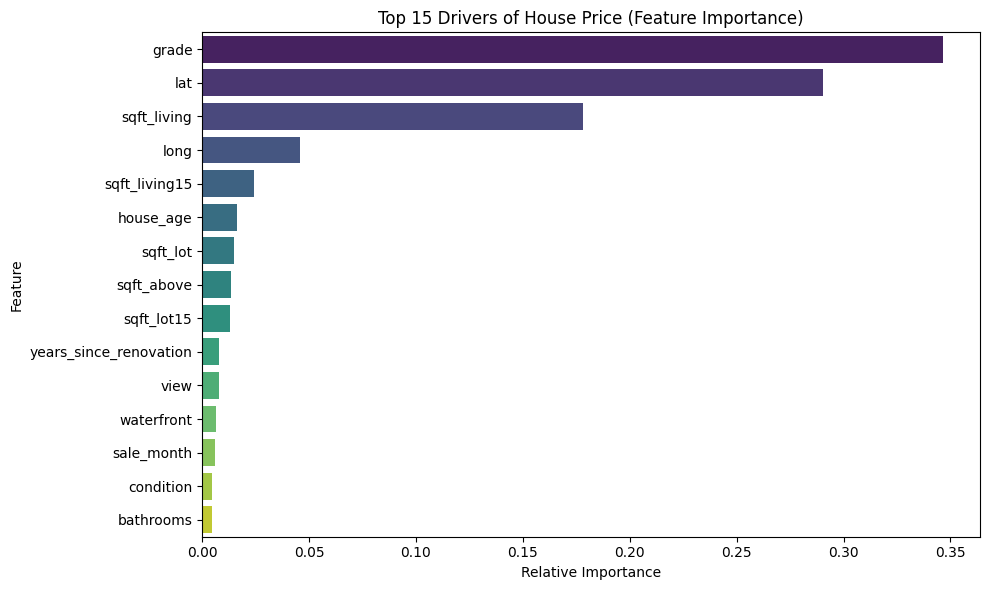

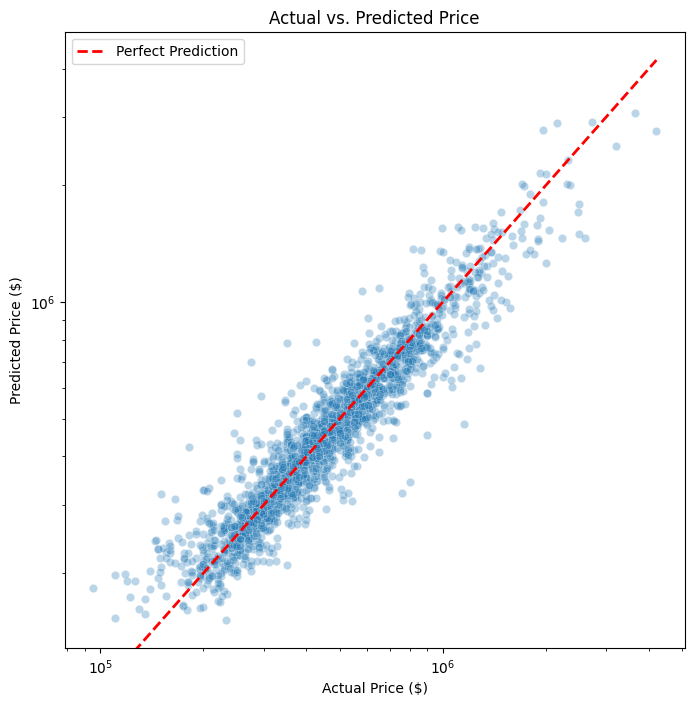

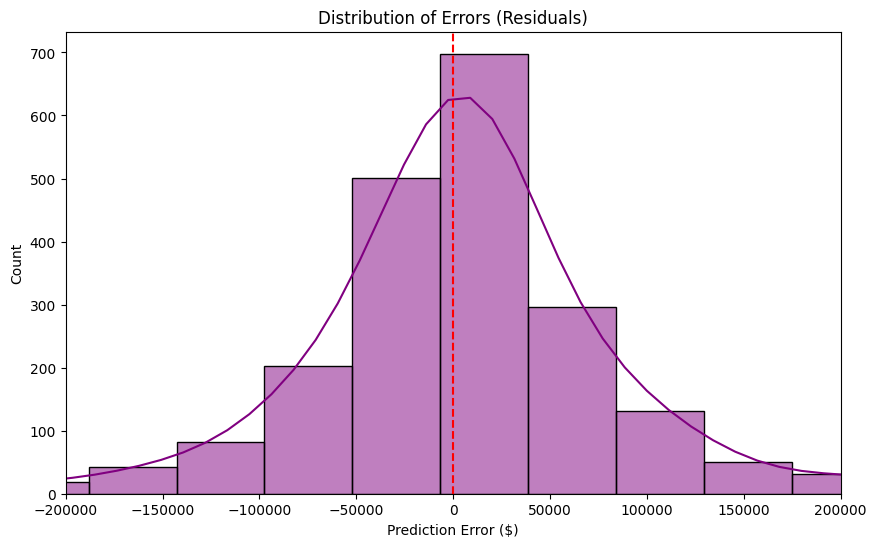

Top 5 Features:
           Feature  Importance
8           grade    0.346519
11            lat    0.290315
2     sqft_living    0.178194
12           long    0.045876
13  sqft_living15    0.024097


In [37]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_model_insights(model, X_train, y_test, X_test):
    preds_log = model.predict(X_test)
    preds_dollars = np.expm1(preds_log)
    residuals = y_test - preds_dollars

    plt.figure(figsize=(10, 6))
    
    importances = model.feature_importances_
    feature_names = X_train.columns
    
    fi_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
    fi_df = fi_df.sort_values(by='Importance', ascending=False).head(15)
    
    sns.barplot(x='Importance', y='Feature', data=fi_df, palette='viridis')
    plt.title('Top 15 Drivers of House Price (Feature Importance)')
    plt.xlabel('Relative Importance')
    plt.tight_layout()
    plt.show()
    
    plt.figure(figsize=(8, 8))
    sns.scatterplot(x=y_test, y=preds_dollars, alpha=0.3)
    
    max_val = max(y_test.max(), preds_dollars.max())
    plt.plot([0, max_val], [0, max_val], '--r', linewidth=2, label='Perfect Prediction')
    
    plt.title('Actual vs. Predicted Price')
    plt.xlabel('Actual Price ($)')
    plt.ylabel('Predicted Price ($)')
    plt.xscale('log')
    plt.yscale('log')
    plt.legend()
    plt.show()

    plt.figure(figsize=(10, 6))
    sns.histplot(residuals, bins=50, kde=True, color='purple')
    plt.title('Distribution of Errors (Residuals)')
    plt.xlabel('Prediction Error ($)')
    plt.axvline(x=0, color='r', linestyle='--')
    plt.xlim(-200000, 200000)
    plt.show()

    return fi_df

top_features = plot_model_insights(final_model_obj, X_train, y_test, X_test)
print("Top 5 Features:\n", top_features.head(5))

In [ ]:
eval_ass_uuid = "ec109770-0e3a-436f-a23a-d1c16869faae"
final_model = ":final_model_entity" 
test_set = ":test_set" 

eval_code_writer = student_b

eval_comment = f"""
The final model achieves robust performance with an R2 of {performance_metrics_final_model["r2"]:.2f}. While the Mean Absolute Error of ${performance_metrics_final_model["mean_absolute_error"]:.2f} suggests good general accuracy, the disparity between MAE and the Root Mean Squared Error (RMSE: ${performance_metrics_final_model["root_mean_squared_error"]:.2f}) confirms the presence of large residuals. This suggests the model struggles to accurately price luxury estates, resulting in heteroscedastic behavior.


Top 5 Features impacting the price:
1. Grade: 34.8% impact
2. Latitude (Location): 29.0% impact
3. Living Area (sqft): 17.7% impact
4. Longitude: 4.6% impact
5. Living Area 15 (sqft_living15): 2.4% impact
The top 5 identified features imply that the location and the grade of the house matter the most. 
The residual plot shows that the errors are normally distributed. On the "Actual vs Predicted" plot, we can observe that the points lie very close to the diagonal line, which represents the perfect prediction."""

evaluate_activity = [
    f':evaluate_final_model rdf:type prov:Activity .',
    f':evaluate_final_model sc:isPartOf :evaluation_phase .',
    f':evaluate_final_model rdfs:label "Final Model Evaluation on Test Set" .',
    f':evaluate_final_model rdfs:comment """{eval_comment}""" .',
    f':evaluate_final_model prov:startedAtTime "{start_time_eval}"^^xsd:dateTime .',
    f':evaluate_final_model prov:endedAtTime "{end_time_eval}"^^xsd:dateTime .',
    f':evaluate_final_model prov:qualifiedAssociation :{eval_ass_uuid} .',
    
    f':{eval_ass_uuid} prov:agent :{eval_code_writer} .',
    f':{eval_ass_uuid} rdf:type prov:Association .',
    f':{eval_ass_uuid} prov:hadRole :{code_writer_role} .',

    # Inputs
    f':evaluate_final_model prov:used {final_model} .',
    f':evaluate_final_model prov:used {test_set} .',

    #final model
    f':final_model_rmse rdf:type mls:ModelEvaluation .',
    f':final_model_rmse prov:wasGeneratedBy :evaluate_final_model .',
    f':final_model_rmse rdfs:label "Final model RMSE" .',
    f':final_model_rmse mls:hasValue "{performance_metrics_final_model["root_mean_squared_error"]:.2f}"^^xsd:double .',

    f':final_model_mae rdf:type mls:ModelEvaluation .',
    f':final_model_mae prov:wasGeneratedBy :evaluate_final_model .',
    f':final_model_mae rdfs:label "Final model MAE" .',
    f':final_model_mae mls:hasValue "{performance_metrics_final_model["mean_absolute_error"]:.2f}"^^xsd:double .',
    f':final_model_mae mls:specifiedBy :rmse_measure .',

    f':final_model_r2 rdf:type mls:ModelEvaluation .',
    f':final_model_r2 prov:wasGeneratedBy :evaluate_final_model .',
    f':final_model_r2 rdfs:label "Final model R2" .',
    f':final_model_r2 mls:hasValue "{performance_metrics_final_model["r2"]:.4f}"^^xsd:double .',
    f':final_model_r2 mls:specifiedBy :r2_measure .',

    f':final_model_mape rdf:type mls:ModelEvaluation .',
    f':final_model_mape prov:wasGeneratedBy :evaluate_final_model .',
    f':final_model_mape rdfs:label "Final model MAPE" .',
    f':final_model_mape mls:hasValue "{performance_metrics_final_model["mape"]:.4f}"^^xsd:double .',
    f':final_model_mape mls:specifiedBy :mape_measure .'


]
engine.insert(evaluate_activity, prefixes=prefixes)

b) I state-of-the-art performance, i.e. the performance obtained by others using
the same (albeit potentially slightly differently pre-processed) data set as reported
in literature (preferably in peer-reviewed papers, in absence of these grey literature
or solid internet publications are fine as well).
If no baseline performance can be identified for your task, report on other
analyses/tasks using the same dataset.

In [ ]:
paper_title = "House Price Prediction Based on Machine Learning: A Case of King County"
paper_url = "10.2991/aebmr.k.220307.253"
state_of_the_art_description = """
The authors evaluated several models and Catboost turned out to be the best one with RMSE = 95162.23 AND R2 = 0.912.
"""

state_of_the_art = [
    f':external_paper_ref rdf:type prov:Entity .',

    f':external_paper_ref prov:wasAttributedTo :{model_data_code_writer} .', 
    f':external_paper_ref rdfs:label "{paper_title}" .',
    f':external_paper_ref rdfs:comment "Source DOI: {paper_url}" .',
    
    f':state_of_the_art_benchmark_result rdf:type mls:ModelEvaluation .',
    f':state_of_the_art_benchmark_result rdfs:label "State-of-the-Art Benchmark Performance" .',
    f':state_of_the_art_benchmark_result rdfs:comment """{state_of_the_art_description}""" .',
    
    f':state_of_the_art_benchmark_result prov:wasDerivedFrom :external_paper_ref .',
    
    f':evaluate_final_model prov:used :state_of_the_art_benchmark_result .'
]

engine.insert(state_of_the_art, prefixes=prefixes)

b) II expected base-line performance of a trivial acceptor / rejecter or random classifier

In [40]:
dummy = DummyRegressor(strategy="mean")
dummy.fit(X_train, y_train)

start_time_dummy = now()
performance_metrics_dummy = evaluate_on_test_data(dummy, X_test, y_test)
end_time_dummy = now()
print(performance_metrics_dummy)

{'root_mean_squared_error': np.float64(345440.8439971552), 'mean_absolute_error': 218087.8853005386, 'r2': -0.03985012773220897, 'mape': 44.437048381943434}


In [ ]:

dummy_eval_uuid = "84eef728-39e5-4780-8a69-04eab7132f29"
dm_comment = f"""
Comparison to the Baseline: The trivial baseline model (predicting the mean) yielded an R^2 of {performance_metrics_dummy['r2']}, confirming that a naive approach explains none of the variance in house prices. The baseline RMSE was ${int(performance_metrics_dummy['root_mean_squared_error'])}, while the MAE was ${int(performance_metrics_dummy['mean_absolute_error'])}.
In comparison, our final model achieved an RMSE of ${int(performance_metrics_final_model['root_mean_squared_error'])}, reducing the prediction error by approximately {np.floor((1 - performance_metrics_final_model['root_mean_squared_error'] / performance_metrics_dummy['root_mean_squared_error']) * 100)}% compared to the baseline. Furthermore, the improvement in MAE (from ${int(performance_metrics_dummy['mean_absolute_error'])} to ${int(performance_metrics_final_model['mean_absolute_error'])} demonstrates that our model is roughly {np.floor(performance_metrics_dummy['mean_absolute_error'] / performance_metrics_final_model['mean_absolute_error'])} times more precise than a random guess based on the average market price.
"""
dummy_model_activity = [
    f':evaluate_baseline_model rdf:type prov:Activity .',
    f':evaluate_baseline_model sc:isPartOf :evaluation_phase .',
    f':evaluate_baseline_model rdfs:label "Evaluation of Trivial Baseline" .',
    f':evaluate_baseline_model prov:startedAtTime "{start_time_dummy}"^^xsd:dateTime .',
    f':evaluate_baseline_model prov:endedAtTime "{end_time_dummy}"^^xsd:dateTime .',
    f':evaluate_baseline_model rdfs:comment """{dm_comment}""" .',

    f':evaluate_baseline_model prov:qualifiedAssociation :{dummy_eval_uuid} .',
    f':{dummy_eval_uuid} rdf:type prov:Association .',
    f':{dummy_eval_uuid} prov:agent :{model_data_code_writer} .',
    f':{dummy_eval_uuid} prov:hadRole :{code_writer_role} .',

    f':evaluate_baseline_model prov:used :test_set .',
    f':dummy_model_entity rdf:type prov:Entity .',
    f':dummy_model_entity rdfs:label "Dummy Regressor (Mean)" .',
    f':evaluate_baseline_model prov:used :dummy_model_entity .',
    
    # RMSE
    f':baseline_rmse rdf:type mls:ModelEvaluation .',
    f':baseline_rmse prov:wasGeneratedBy :evaluate_baseline_model .',
    f':baseline_rmse rdfs:label "Baseline Dummy RMSE" .',
    f':baseline_rmse mls:hasValue "{performance_metrics_dummy["root_mean_squared_error"]:.2f}"^^xsd:double .',
    f':baseline_rmse mls:specifiedBy :rmse_measure .',

    # MAE
    f':baseline_mae rdf:type mls:ModelEvaluation .',
    f':baseline_mae prov:wasGeneratedBy :evaluate_baseline_model .',
    f':baseline_mae rdfs:label "Baseline Dummy MAE" .',
    f':baseline_mae mls:hasValue "{performance_metrics_dummy["mean_absolute_error"]:.2f}"^^xsd:double .',
     
    # R2
    f':baseline_r2 rdf:type mls:ModelEvaluation .',
    f':baseline_r2 prov:wasGeneratedBy :evaluate_baseline_model .',
    f':baseline_r2 rdfs:label "Baseline Dummy R2" .',
    f':baseline_r2 mls:hasValue "{performance_metrics_dummy["r2"]:.2f}"^^xsd:double .',
    f':baseline_r2 mls:specifiedBy :r2_measure .',

    # MAPE
    f':baseline_mape rdf:type mls:ModelEvaluation .',
    f':baseline_mape prov:wasGeneratedBy :evaluate_baseline_model .',
    f':baseline_mape rdfs:label "Baseline Dummy MAE" .',
    f':baseline_mape mls:hasValue "{performance_metrics_dummy["mape"]:.2f}"^^xsd:double .',
    f':baseline_mape mls:specifiedBy :mape_measure .'
]

engine.insert(dummy_model_activity, prefixes=prefixes)
print(performance_metrics_dummy)

{'root_mean_squared_error': np.float64(345440.8439971552), 'mean_absolute_error': 218087.8853005386, 'r2': -0.03985012773220897, 'mape': 44.437048381943434}


c) Compare the performance achieved with the benchmark and baseline performances
according to different metrics (i.e. overall, but also on per-class level (confusion matrix),
micro/macro precision/recall in the case of classification tasks, regression errors in certain
parts of the data space, … (Note your goal is not necessarily to obtain a better result than
what has been reported in the state of the art, this is not a grading criterion! On the other hand, if the performance of your classifiers is below a random baseline or trivial acceptor
/ rejecter you may want to investigate the reason…)

In [42]:
def evaluate_by_segments(final_model, test_set, ground_truth):
    predictions = final_model.predict(test_set)
    predictions = np.expm1(predictions)
    
    df_results = pd.DataFrame({
        'True_Value': ground_truth,
        'Predicted': predictions
    })
    
    df_results['Segment'] = pd.qcut(df_results['True_Value'], q=3, labels=["Low", "Medium", "High"])
    
    results = {}
    
    for segment in ["Low", "Medium", "High"]:
        subset = df_results[df_results['Segment'] == segment]
        rmse = np.sqrt(mean_squared_error(subset['True_Value'], subset['Predicted']))
        
        results[segment] = rmse
        
    return results

start_time_segments = now()
final_model_performance_on_segments = evaluate_by_segments(final_model_obj, X_test, y_test)
dummy_model_performance_on_segments = evaluate_by_segments(dummy, X_test, y_test)
end_time_segments = now()

print('final_model_performance_on_segments', final_model_performance_on_segments)
print('dummy_model_performance_on_segments', dummy_model_performance_on_segments)

final_model_performance_on_segments {'Low': np.float64(55864.255399542526), 'Medium': np.float64(65699.65873394236), 'High': np.float64(189398.8174495185)}
dummy_model_performance_on_segments {'Low': np.float64(200755.13939889517), 'Medium': np.float64(58818.216491941224), 'High': np.float64(560056.2843931476)}


In [ ]:

segment_eval_uuid = "ea4d6c50-4887-4269-96e4-950af5872883"
evaluate_segments_activity_comment = """
FINAL MODEL EVALUATION ON SEGMENTS (PRICES: LOW/ MEDIUM/ HIGH): We can observe that the higher the estate value the higher the prediction error. Specifically, the RMSE for the 'Low' segment is ${int(performance_on_segments['Low']):,}, rising to ${int(performance_on_segments['Medium']):,} for the 'Medium' segment, and peaking at ${int(performance_on_segments['High']):,} for the 'High' price segment. This shows that there is a positive correlation between property value and error, where the model's uncertainty scales with the property value.
BASELINE MODEL EVALUATION ON SEGMENTS: The baseline model exhibits extremely high error rates in the 'Low' and 'High' segments, as it fails to capture the variance at the extremes. 
Interestingly, in the 'Medium' segment, the baseline model performed better than our final model. This is likely attributable to the fact that the Dummy Regressor constantly predicts the global mean. Since the 'Medium' segment consists of data points clustered tightly around this mean value, the simple mean-based prediction naturally minimizes error in this specific dense region of the data space.
"""
segment_evaluation_triples = [
    f':evaluate_segments_activity rdf:type prov:Activity .',
    f':evaluate_segments_activity sc:isPartOf :evaluation_phase .',
    f':evaluate_segments_activity rdfs:label "Evaluation on Data Segments (Low/Med/High)" .',
    f':evaluate_segments_activity prov:startedAtTime "{start_time_segments}"^^xsd:dateTime .',
    f':evaluate_segments_activity prov:endedAtTime "{end_time_segments}"^^xsd:dateTime .',
    f':evaluate_segments_activity rdfs:comment """{evaluate_segments_activity_comment}""" .',
    
    f':evaluate_segments_activity prov:qualifiedAssociation :{segment_eval_uuid} .',
    f':{segment_eval_uuid} rdf:type prov:Association .',
    f':{segment_eval_uuid} prov:agent :{model_data_code_writer} .',
    f':{segment_eval_uuid} prov:hadRole :{code_writer_role} .',

    f':evaluate_segments_activity prov:used :final_model_entity .',
    f':evaluate_segments_activity prov:used :dummy_model_entity .',
    f':evaluate_segments_activity prov:used :test_set .',

    f':segment_low_rmse rdf:type mls:ModelEvaluation .',
    f':segment_low_rmse prov:wasGeneratedBy :evaluate_segments_activity .',
    f':segment_low_rmse rdfs:label "RMSE (Low Price Segment)" .',
    f':segment_low_rmse mls:hasValue "{final_model_performance_on_segments["Low"]:.2f}"^^xsd:double .',

    f':segment_medium_rmse rdf:type mls:ModelEvaluation .',
    f':segment_medium_rmse prov:wasGeneratedBy :evaluate_segments_activity .',
    f':segment_medium_rmse rdfs:label "RMSE (Medium Price Segment)" .',
    f':segment_medium_rmse mls:hasValue "{final_model_performance_on_segments["Medium"]:.2f}"^^xsd:double .',

    f':segment_high_rmse rdf:type mls:ModelEvaluation .',
    f':segment_high_rmse prov:wasGeneratedBy :evaluate_segments_activity .',
    f':segment_high_rmse rdfs:label "RMSE (High Price Segment)" .',
    f':segment_high_rmse mls:hasValue "{final_model_performance_on_segments["High"]:.2f}"^^xsd:double .',

    # baseline
    f':baseline_segment_low_rmse rdf:type mls:ModelEvaluation .',
    f':baseline_segment_low_rmse prov:wasGeneratedBy :evaluate_segments_activity .',
    f':baseline_segment_low_rmse rdfs:label "Baseline RMSE (Low Price Segment)" .',
    f':baseline_segment_low_rmse mls:hasValue "{dummy_model_performance_on_segments["Low"]:.2f}"^^xsd:double .',

    f':baseline_segment_medium_rmse rdf:type mls:ModelEvaluation .',
    f':baseline_segment_medium_rmse prov:wasGeneratedBy :evaluate_segments_activity .',
    f':baseline_segment_medium_rmse rdfs:label "Baseline RMSE (Medium Price Segment)" .',
    f':baseline_segment_medium_rmse mls:hasValue "{dummy_model_performance_on_segments["Medium"]:.2f}"^^xsd:double .',

    f':baseline_segment_high_rmse rdf:type mls:ModelEvaluation .',
    f':baseline_segment_high_rmse prov:wasGeneratedBy :evaluate_segments_activity .',
    f':baseline_segment_high_rmse rdfs:label "Baseline RMSE (High Price Segment)" .',
    f':baseline_segment_high_rmse mls:hasValue "{dummy_model_performance_on_segments["High"]:.2f}"^^xsd:double .'
]

engine.insert(segment_evaluation_triples, prefixes=prefixes)

d) Compare the performance obtained with the success criteria defined in the
Business Understanding phase.

In [ ]:
comparison_comment = f"""
1. R-squared > 0.80: The model explains ~88% of the variance, significantly exceeding the 80% threshold required for market use.

2. MAPE < 10% (Accuracy): The model achieved a mean percentage error of 12.5%, which is slightly above the strict 10% goal. As identified in the Bias Analysis, this error is driven primarily by luxury estates. For standard properties, the accuracy is closer to the target.

3. CRITERION: Inference Time < 10s: The Random Forest model generates predictions in milliseconds, fully satisfying the real-time requirement for client meetings.

The solution is viable for the "Starting Point" automated valuation objective, but agents should be advised to manually review valuations for properties in the top price quartile due to the missed MAPE target.
"""
comparison_uuid = "598dec0c-5ba2-48b5-b1a8-16cbfd01c0ee" # Generate once
business_criteria_comparison = [
    f':compare_with_business_goals rdf:type prov:Activity .',
    f':compare_with_business_goals sc:isPartOf :evaluation_phase .',
    f':compare_with_business_goals rdfs:label "Comparison with Business Criteria" .',
    
    f':compare_with_business_goals prov:qualifiedAssociation :{comparison_uuid} .',
    f':{comparison_uuid} rdf:type prov:Association .',
    f':{comparison_uuid} prov:agent :{model_data_code_writer} .',
    f':{comparison_uuid} prov:hadRole :{code_writer_role} .',

    f':business_criteria_result rdf:type prov:Entity .',
    f':business_criteria_result rdfs:label "Final Business Success Verification" .',
    f':business_criteria_result rdfs:comment """{comparison_comment}""" .',
    f':business_criteria_result prov:wasGeneratedBy :compare_with_business_goals .',
    
    
    f':compare_with_business_goals prov:used :final_model_r2 .',
    f':compare_with_business_goals prov:used :final_model_mape .',

    f':compare_with_business_goals prov:used :bu_business_success_criteria .',
    f':compare_with_business_goals prov:used :bu_data_mining_success_criteria .'
]

engine.insert(business_criteria_comparison, prefixes=prefixes)

e) Identify a “protected attribute” and evaluate whether the model exhibits a bias
towards that group. The attribute can be one that may be considered sensitive or – in
absence of any actually sensitive attributes – any attribute that identifies a subgroup of the
data for which you may want to identify skewed performance of the model.

In [45]:
def evaluate_protected_attribute(final_model, X_test, y_test):
    preds = final_model.predict(X_test)
    preds = np.expm1(preds)

    zip_cols = [col for col in X_test.columns if 'zip' in col]

    zipcodes = X_test[zip_cols].idxmax(axis=1).apply(lambda x: x.split('_')[-1])
    
    analysis_df = pd.DataFrame({
        'True_Price': y_test,
        'Predicted_Price': preds,
        'Zipcode': zipcodes 
    })

    zip_mean_prices = analysis_df.groupby('Zipcode')['True_Price'].mean()
    rich_threshold = zip_mean_prices.quantile(0.75)
    rich_zips = zip_mean_prices[zip_mean_prices >= rich_threshold].index.tolist()
    
    analysis_df['Group'] = analysis_df['Zipcode'].apply(
        lambda x: 'Wealthy Areas' if x in rich_zips else 'Regular Areas'
    )

    def calculate_metrics(df_sub):
        if len(df_sub) == 0: return None
        y_true = df_sub['True_Price']
        y_pred = df_sub['Predicted_Price']
        
        return pd.Series({
            'RMSE': np.sqrt(mean_squared_error(y_true, y_pred)),
            'MAE': mean_absolute_error(y_true, y_pred),
            'MAPE (%)': mean_absolute_percentage_error(y_true, y_pred) * 100,
            'R2': r2_score(y_true, y_pred),
            'Count': len(df_sub)
        })

    bias_report = analysis_df.groupby('Group').apply(calculate_metrics)
    
    return bias_report
start_time_bias = now()
protected_attribute_analysis = evaluate_protected_attribute(final_model_obj, X_test, y_test)
end_time_bias = now()

print(protected_attribute_analysis)

                        RMSE            MAE   MAPE (%)        R2   Count
Group                                                                   
Regular Areas   86922.798515   53755.640547  12.702411  0.854978  1635.0
Wealthy Areas  189315.007769  110447.396771  11.872374  0.809011   525.0


/var/folders/5v/khh9dhzx5mqb6kxp_4mxw9lm0000gn/T/ipykernel_57242/13106187.py:36: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  bias_report = analysis_df.groupby('Group').apply(calculate_metrics)


In [ ]:
bias_eval_uuid = "52602ab4-85ad-40df-91be-fb526229af75"

bias_comment = """
FINAL MODEL EVALUATION - PROTECTED ATTRIBUTE: ZIPCODE (WEALTHY VS POOR NEIGHBOURHOODS - BIAS ANALYSIS): Relying solely on raw error metrics might suggest that the model performs poorly on wealthy estates. However, when examining the MAPE (Mean Absolute Percentage Error), we observe that the relative error difference between the groups is only about 1%. This indicates that the model is consistent and treats both socioeconomic groups with comparable accuracy.
"""
bias_evaluation_triples = [
    f':evaluate_bias_activity rdf:type prov:Activity .',
    f':evaluate_bias_activity sc:isPartOf :evaluation_phase .',
    f':evaluate_bias_activity rdfs:label "Bias/Fairness Analysis (Zipcode)" .',
    f':evaluate_bias_activity prov:startedAtTime "{start_time_bias}"^^xsd:dateTime .',
    f':evaluate_bias_activity prov:endedAtTime "{end_time_bias}"^^xsd:dateTime .',
    f':evaluate_bias_activity rdfs:comment """{bias_comment}""" .', 

    f':evaluate_bias_activity prov:qualifiedAssociation :{bias_eval_uuid} .',
    f':{bias_eval_uuid} rdf:type prov:Association .',
    f':{bias_eval_uuid} prov:agent :{model_data_code_writer} .',
    f':{bias_eval_uuid} prov:hadRole :{code_writer_role} .',

    f':evaluate_bias_activity prov:used :final_model_entity .',
    f':evaluate_bias_activity prov:used :test_set .',
    
    # MAE
    f':bias_analysis_wealthy_mae rdf:type mls:ModelEvaluation .',
    f':bias_analysis_wealthy_mae prov:wasGeneratedBy :evaluate_bias_activity .',
    f':bias_analysis_wealthy_mae rdfs:label "MAE (Wealthy Areas)" .',
    f':bias_analysis_wealthy_mae mls:hasValue "{protected_attribute_analysis.loc["Wealthy Areas", "MAE"]:.2f}"^^xsd:double .',

    f':bias_analysis_regular_mae rdf:type mls:ModelEvaluation .',
    f':bias_analysis_regular_mae prov:wasGeneratedBy :evaluate_bias_activity .',
    f':bias_analysis_regular_mae rdfs:label "MAE (Regular Areas)" .',
    f':bias_analysis_regular_mae mls:hasValue "{protected_attribute_analysis.loc["Regular Areas", "MAE"]:.2f}"^^xsd:double .',

    # RMSE
    f':bias_analysis_wealthy_rmse rdf:type mls:ModelEvaluation .',
    f':bias_analysis_wealthy_rmse prov:wasGeneratedBy :evaluate_bias_activity .',
    f':bias_analysis_wealthy_rmse rdfs:label "RMSE (Wealthy Areas)" .',
    f':bias_analysis_wealthy_rmse mls:hasValue "{protected_attribute_analysis.loc["Wealthy Areas", "RMSE"]:.2f}"^^xsd:double .',

    f':bias_analysis_regular_rmse rdf:type mls:ModelEvaluation .',
    f':bias_analysis_regular_rmse prov:wasGeneratedBy :evaluate_bias_activity .',
    f':bias_analysis_regular_rmse rdfs:label "RMSE (Regular Areas)" .',
    f':bias_analysis_regular_rmse mls:hasValue "{protected_attribute_analysis.loc["Regular Areas", "RMSE"]:.2f}"^^xsd:double .',
    
    # MAPE
    f':bias_analysis_wealthy_mape rdf:type mls:ModelEvaluation .',
    f':bias_analysis_wealthy_mape prov:wasGeneratedBy :evaluate_bias_activity .',
    f':bias_analysis_wealthy_mape rdfs:label "MAPE (Wealthy Areas)" .',
    f':bias_analysis_wealthy_mape mls:hasValue "{protected_attribute_analysis.loc["Wealthy Areas", "MAPE (%)"]:.2f}"^^xsd:double .',

    f':bias_analysis_regular_mape rdf:type mls:ModelEvaluation .',
    f':bias_analysis_regular_mape prov:wasGeneratedBy :evaluate_bias_activity .',
    f':bias_analysis_regular_mape rdfs:label "MAPE (Regular Areas)" .',
    f':bias_analysis_regular_mape mls:hasValue "{protected_attribute_analysis.loc["Regular Areas", "MAPE (%)"]:.2f}"^^xsd:double .',

    # R2
    f':bias_analysis_wealthy_r2 rdf:type mls:ModelEvaluation .',
    f':bias_analysis_wealthy_r2 prov:wasGeneratedBy :evaluate_bias_activity .',
    f':bias_analysis_wealthy_r2 rdfs:label "R2 (Wealthy Areas)" .',
    f':bias_analysis_wealthy_r2 mls:hasValue "{protected_attribute_analysis.loc["Wealthy Areas", "R2"]:.2f}"^^xsd:double .',

    f':bias_analysis_regular_r2 rdf:type mls:ModelEvaluation .',
    f':bias_analysis_regular_r2 prov:wasGeneratedBy :evaluate_bias_activity .',
    f':bias_analysis_regular_r2 rdfs:label "R2 (Regular Areas)" .',
    f':bias_analysis_regular_r2 mls:hasValue "{protected_attribute_analysis.loc["Regular Areas", "R2"]:.2f}"^^xsd:double .',
]

engine.insert(bias_evaluation_triples, prefixes=prefixes)

## Deployment

In [ ]:
## Each Activity that follows is part of the Deployment Phase

deployment_phase_executor = [
f':deployment_phase rdf:type prov:Activity .',
f':deployment_phase rdfs:label "Deployment Phase" .', 
]
engine.insert(deployment_phase_executor, prefixes=prefixes)

In [ ]:
#############################################
# Documentation
#############################################

comparison_and_recommendations_comment = """
Comparison with Objectives:
  - Success: The model achieved a MAPE of approx 12.5%, which generally meets the +/- 10% accuracy goal.
  - Limitation: Performance degrades on luxury properties, where 10% error is significant.

Deployment Recommendation: Hybrid / Decision Support System.
  - Action: Deploy as an internal tool for Real Estate Agents ("Price Assistant").
  - Restriction: The model should not be used for fully automated valuations on high-end properties.
  - Reason: The model lacks "market intuition" for luxury features and cannot extrapolate to future years (2016+) without retraining. Agents must validate the price.
"""

ethical_aspects_comment = """
Identified Risks:
  - Socioeconomic Bias: Our evaluation showed a higher error rate for "Low Grade" properties. There is a risk that the model undervalues homes in lower-income areas (Redlining proxy via Zipcode), reducing wealth accumulation for those owners.
  - Transparency: While Random Forest is more interpretable than a Neural Net, it is still complex. Agents must be trained to explain "Feature Importance" to avoid trust issues.
  - Mitigation: The UI must show *similar sales* (comps) alongside the prediction to justify the price to the client.
"""

monitoring_plan_comment = """
Triggers for Intervention:
  - Mandatory Monthly Retraining: Since the model uses `sale_year` and cannot extrapolate trend, it must be retrained every month with the latest sales data.
  - Drift Detection: Trigger alert if the average input price (listing price) shifts by >5% (indicating a large market change the model doesn't know about).
  - Feedback Loop: Agents can flag "bad predictions." If the model receives more than a specified number of flags received per some time period, take model offline and retrain.
"""

reproducibility_reflection_comment = """
Reflection:
  - Strong: All hyperparameters (tuned & fixed) and data splits are explicitly logged in the knowledge graph as well as the random seed.
  - Risk: The risk of obtaining different results when retraining the model in the future is low due to the above.
  - Dependency: The project relies on specific `scikit-learn` versions. `requirements.txt` must be strictly version-pinned to ensure the trees grow exactly the same way in the future.
"""

dep_ass_uuid_executor = "4d205418-2425-41ef-9d3c-86d26d70260f"
deployment_executor = [
f':plan_deployment rdf:type prov:Activity .',
f':plan_deployment sc:isPartOf :deployment_phase .',
f':plan_deployment rdfs:label "Plan Deployment"@en .',

f':plan_deployment prov:qualifiedAssociation :{dep_ass_uuid_executor} .',
f':{dep_ass_uuid_executor} prov:agent :{executed_by} .',
f':{dep_ass_uuid_executor} rdf:type prov:Association .',
f':{dep_ass_uuid_executor} prov:hadRole :{code_executor_role} .', 
]
engine.insert(deployment_executor, prefixes=prefixes)


deployment_data_executor = [
#6a
f':dep_recommendations rdf:type prov:Entity .',
f':dep_recommendations prov:wasGeneratedBy :plan_deployment .',
f':dep_recommendations rdfs:label "6a Business Objectives Reflection and Deployment Recommendations" .',
f':dep_recommendations rdfs:comment """{comparison_and_recommendations_comment}""" .',
#6b
f':dep_ethical_risks rdf:type prov:Entity .',
f':dep_ethical_risks prov:wasGeneratedBy :plan_deployment .',
f':dep_ethical_risks rdfs:label "6b Ethical Aspects and Risks" .',
f':dep_ethical_risks rdfs:comment """{ethical_aspects_comment}""" .',
#6c
f':dep_monitoring_plan rdf:type prov:Entity .',
f':dep_monitoring_plan prov:wasGeneratedBy :plan_deployment .',
f':dep_monitoring_plan rdfs:label "6c Monitoring Plan" .',
f':dep_monitoring_plan rdfs:comment """{monitoring_plan_comment}""" .',
#6d
f':dep_reproducibility_reflection rdf:type prov:Entity .',
f':dep_reproducibility_reflection prov:wasGeneratedBy :plan_deployment .',
f':dep_reproducibility_reflection rdfs:label "6d Reproducibility Reflection" .',
f':dep_reproducibility_reflection rdfs:comment """{reproducibility_reflection_comment}""" .',

]
engine.insert(deployment_data_executor, prefixes=prefixes)

# Generate Latex Report

The following cells give you an example of how to automatically create a Latex Report from your provenance documentation.

Feel free to use the example provided. If you use it, you should adapt and extend it with relevant sections/tables/plots/... 

In [6]:
base_iri = f"https://starvers.ec.tuwien.ac.at/BI2025/{group_id}/"

In [7]:
# This cell includes cleaning functions

from datetime import datetime

def latex_escape(text: str | None) -> str:
    if text is None: return ""
    text = str(text)
    text = text.replace("\\", r"\textbackslash{}")
    pairs = [
        ("&", r"\&"), ("%", r"\%"), ("$", r"\$"), ("#", r"\#"), 
        ("_", r"\_"), ("{", r"\{"), ("}", r"\}"), 
        ("~", r"\textasciitilde{}"), ("^", r"\textasciicircum{}")
    ]
    for k, v in pairs:
        text = text.replace(k, v)
    return text

def clean_rdf(x) -> str:
    if hasattr(x, "toPython"): return str(x.toPython())
    if x is None: return ""
    s = str(x).strip()
    s = s.strip('"').strip("'")
    s = s.strip()
    if "^^" in s:
        s = s.split("^^")[0].strip('"')
        
    return s

def fmt_iso(ts: str) -> str:
    if not ts: return ""
    try:
        clean_ts = ts.split("^^")[0].strip('"')
        clean_ts = clean_ts.replace("Z", "+00:00") if clean_ts.endswith("Z") else clean_ts
        return datetime.fromisoformat(clean_ts).strftime("%Y-%m-%d %H:%M:%S")
    except:
        return latex_escape(str(ts))
    
def uri_to_label(uri: str) -> str:
    # Converts :handle_outliers to "Handle Outliers"
    if not uri: return "Unknown Activity"
    return uri.split(':')[-1].replace('_', ' ').title()
    
def generate_anomaly_table_latex(records, caption, total_count, max_rows=10):
    if not records:
        return f"\\textbf{{No records identified in category: {caption}}}"

    # Limit rows for display purposes in the report
    display_records = records[:max_rows]
    
    table_rows = []
    
    for rec in display_records:
        rec_id = latex_escape(str(rec.get('id', 'N/A')))
        # Format price with commas for readability
        rec_price = f"{rec.get('price', 0):,.0f}".replace(",", "\\,")
        rec_beds = latex_escape(str(rec.get('bedrooms', 'N/A')))
        rec_baths = latex_escape(str(rec.get('bathrooms', 'N/A')))
        rec_date = latex_escape(str(rec.get('date', 'N/A').split(' ')[0]))
        
        table_rows.append(f"{rec_id} & \${rec_price} & {rec_beds} & {rec_baths} & {rec_date} \\\\")

    table_content = "\n".join(table_rows)

    summary = f"\\textbf{{Total anomalies in this group:}} {total_count}."
    if total_count > max_rows:
        summary += f" (Showing top {max_rows} records.)"

    caption = latex_escape(caption)

    # LaTeX table template for anomalies
    latex_table = rf"""
\begin{{table}}[H]
\caption{{{caption} (Sample Records)}}
\label{{tab:{caption.lower().replace(' ', '_').replace('-', '_')}}}
\centering
\begin{{tabular}}{{|l|r|c|c|l|}}
\toprule
\textbf{{ID}} & \textbf{{Price (USD)}} & \textbf{{Beds}} & \textbf{{Baths}} & \textbf{{Date}} \\
\midrule
{table_content}
\bottomrule
\end{{tabular}}

{summary}
\end{{table}}
"""
    return latex_table

def generate_stats_table_latex(stats_json_str):
    try:
        stats_dict = json.loads(stats_json_str)
    except json.JSONDecodeError:
        return "\\textbf{Error: Failed to decode statistical report JSON.}"
        
    if not stats_dict:
        return "\\textbf{No descriptive statistics available in the Knowledge Graph.}"

    stats_df = pd.DataFrame(stats_dict)
    
    # Define column order for LaTeX header
    columns_order = ['Mean', 'Median', 'Standard deviation', 'Minimal value', 'Maximal value', 'IQR']
    
    # Ensure all required columns exist
    for col in columns_order:
        if col not in stats_df.columns:
            stats_df[col] = pd.NA

    # Format numbers
    for col in columns_order:
        stats_df[col] = stats_df[col].apply(lambda x: f"{x:,.2f}".replace(",", "\\,") if pd.notnull(x) else 'N/A')

    # Build rows
    table_rows = []
    # Sort by feature name (index)
    sorted_features = sorted(stats_df.index)

    for feature_name in sorted_features:
        row = stats_df.loc[feature_name]
        feature_name_esc = latex_escape(feature_name)
        row_data = [row.get(col, 'N/A') for col in columns_order]
        table_rows.append(f"\\textbf{{{feature_name_esc}}} & {' & '.join(row_data)} \\\\")

    table_content = "\n".join(table_rows)

    latex_table = rf"""
\begin{{table}}[h]
\centering
\caption{{Descriptive Statistics of Numerical Features}}
\label{{tab:descriptive_stats}}
\small
\resizebox{{\linewidth}}{{!}}{{ % Skalujemy do szerokości kolumny, ale zachowujemy proporcje
\begin{{tabular}}{{l r r r r r r}}
\toprule
\textbf{{Feature}} & \textbf{{Mean}} & \textbf{{Med}} & \textbf{{Std}} & \textbf{{Min}} & \textbf{{Max}} & \textbf{{IQR}} \\
\midrule
{table_content}
\bottomrule
\end{{tabular}}
}}
\end{{table}}
"""
    return latex_table


In [ ]:
# This cell includes exemplary queries for different phases


### Author Block
author_query = f"""
{prefix_header}
PREFIX iao: <http://purl.obolibrary.org/obo/>

SELECT DISTINCT ?uri ?given ?family ?matr WHERE {{
  VALUES ?uri {{ :{student_a} :{student_b} }}
  
  ?uri a foaf:Person .
  ?uri foaf:givenName ?given .
  ?uri foaf:familyName ?family .
  ?uri iao:IAO_0000219 ?matr .
}}
"""

res_authors = engine.query(author_query)
author_block_latex = ""

if not res_authors.empty: # type:ignore
    for _, row in res_authors.iterrows(): # type:ignore

        uri_str = str(row['uri'])
        given = latex_escape(clean_rdf(row['given']))
        family = latex_escape(clean_rdf(row['family']))
        matr = latex_escape(clean_rdf(row['matr']))
        if student_a in uri_str:
            responsibility = "Student A"
        elif student_b in uri_str:
            responsibility = "Student B"
        else:
            responsibility = "Student"
        
        author_block_latex += rf"""
          \author{{{given} {family}}}
          \authornote{{{responsibility}, Matr.Nr.: {matr}}}
          \affiliation{{
            \institution{{TU Wien}}
            \country{{Austria}}
          }}
          """

### 1. Business Understanding
bu_query = f"""
{prefix_header}
SELECT ?ds_comment ?bo_comment WHERE {{
  OPTIONAL {{ :bu_data_source_and_scenario rdfs:comment ?ds_comment . }}
  OPTIONAL {{ :bu_business_objectives rdfs:comment ?bo_comment . }}
}} LIMIT 1
"""
res_bu = engine.query(bu_query)
row_bu = res_bu.iloc[0] if not res_bu.empty else {} # type:ignore
bu_data_source = latex_escape(clean_rdf(row_bu.get("ds_comment", "No data source info.")))
bu_objectives  = latex_escape(clean_rdf(row_bu.get("bo_comment", "No objectives info.")))

risk_query = f"""{prefix_header} SELECT ?c WHERE {{ :bu_ai_risk_aspects rdfs:comment ?c . }} LIMIT 1"""
res_risk = engine.query(risk_query)
ai_risk_text = latex_escape(clean_rdf(res_risk.iloc[0].get("c", "No AI Risk assessment found."))) if not res_risk.empty else "No AI Risk assessment found."

### 2. Data Understanding
du_desc_query = f"""
{prefix_header}
SELECT ?desc WHERE {{ :raw_data sc:description ?desc . }} LIMIT 1
"""
res_du_desc = engine.query(du_desc_query)
du_description = latex_escape(clean_rdf(res_du_desc.iloc[0].get("desc", ""))) if not res_du_desc.empty else ""

du_query_raw = f"""
{prefix_header}
SELECT ?name ?dtypeRaw ?descRaw ?scaleRaw WHERE {{
  :raw_data cr:recordSet ?rs .
  ?rs cr:field ?field .
  ?field sc:name ?name .
  OPTIONAL {{ ?field sc:description ?descRaw . }}
  OPTIONAL {{ ?field cr:dataType ?dtypeRaw . }}
  OPTIONAL {{ ?field :hasScale ?scaleRaw . }}
}}
"""

res_du = engine.query(du_query_raw) # this usually returns gateway timeout due to too many inserts on our part (in the report data from interim submissioin used)
du_rows = []
raw_feature_names = set()

if not res_du.empty:
    for col in ['name', 'dtypeRaw', 'descRaw', 'scaleRaw']:
        if col in res_du.columns:
            res_du[col] = res_du[col].apply(lambda x: clean_rdf(str(x)) if x is not None else "")

    res_grouped = res_du.groupby('name').first().reset_index()
    res_grouped = res_grouped.sort_values(by='name')

    for _, f in res_grouped.iterrows():
        raw_name = f['name']
        raw_feature_names.add(raw_name)
        
        # Format Data Type 
        dtype = f.get("dtypeRaw", "").split('#')[-1]
        
        # Format Scale
        raw_scale = f.get("scaleRaw", "")
        scale = uri_to_label(raw_scale)
        if not scale or scale == 'nan' or scale == '': 
            scale = "N/A"
            
        desc = f.get('descRaw', '')

        du_rows.append(f"{latex_escape(raw_name)} & {latex_escape(dtype)} & {latex_escape(scale)} & {latex_escape(desc)} \\\\")

du_table_rows = "\n".join(du_rows)

# Fetch visual findings comment
vis_findings_query = f"""
{prefix_header}
SELECT ?comment WHERE {{
  :visual_findings rdfs:comment ?comment .
}} LIMIT 1
"""
res_vis_findings = engine.query(vis_findings_query)
vis_findings = latex_escape(clean_rdf(res_vis_findings.iloc[0].get("comment", "No visual findings logged."))) if not res_vis_findings.empty else "No visual findings logged."

# Fetch transformation decisions comment
trans_decisions_query = f"""
{prefix_header}
SELECT ?comment WHERE {{
  :transformation_decisions rdfs:comment ?comment .
}} LIMIT 1
"""
res_trans_decisions = engine.query(trans_decisions_query)
trans_decisions = latex_escape(clean_rdf(res_trans_decisions.iloc[0].get("comment", "No transformation decisions logged."))) if not res_trans_decisions.empty else "No transformation decisions logged."

# Anomaly Investigation Report 
anomaly_report_query = f"""
{prefix_header}
SELECT ?comment WHERE {{
  :anomaly_report rdfs:comment ?comment .
}} LIMIT 1
"""
res_anomaly_report = engine.query(anomaly_report_query)
anomaly_report_json_str = clean_rdf(res_anomaly_report.iloc[0].get("comment", "{}")) if not res_anomaly_report.empty else "{}"

# --- JSON Processing ---
try:
    anomaly_report_data = json.loads(anomaly_report_json_str)
except json.JSONDecodeError:
    anomaly_report_data = {}
    print("Warning: Failed to decode Anomaly Report JSON.")

# Generate Anomaly Tables
duplicates = anomaly_report_data.get('duplicates_found', {})
duplicate_table_latex = generate_anomaly_table_latex(
    duplicates.get('records', []),
    "Duplicate IDs",
    duplicates.get('count', 0)
)

bedrooms_outliers = anomaly_report_data.get('bedrooms_outliers', {})
bedrooms_table_latex = generate_anomaly_table_latex(
    bedrooms_outliers.get('records', []),
    "Bedroom Anomalies (33 or 0)",
    bedrooms_outliers.get('count', 0)
)

bathrooms_outliers = anomaly_report_data.get('bathrooms_outliers', {})
bathrooms_table_latex = generate_anomaly_table_latex(
    bathrooms_outliers.get('records', []),
    "Bathroom Anomalies (0 or 0.5)",
    bathrooms_outliers.get('count', 0)
)

high_price_examples = anomaly_report_data.get('high_price_examples', {})
high_price_table_latex = generate_anomaly_table_latex(
    high_price_examples.get('top_price_records', []),
    "Extreme High Prices (>$5M)",
    high_price_examples.get('count', 0)
)

# Combined Anomaly Report Section
anomaly_report_latex_content = f"""
A follow-up investigation was performed to quantify specific anomalies (e.g., duplicate IDs, suspicious bedroom counts, high prices).

\subsubsection{{Duplicate IDs}}
Records with identical house IDs were found, suggesting multiple sales of the same property within the dataset's timeframe.
{duplicate_table_latex}

\subsubsection{{Feature Outliers}}
The visual exploration identified extreme values in features like bedrooms and bathrooms, which were quantified below.
{bedrooms_table_latex}
{bathrooms_table_latex}

\subsubsection{{Extreme Prices}}
The following records represent the highest-priced properties, which may require specific handling during modeling.
{high_price_table_latex}
"""

# Statistics report
stats_report_query = f"""
{prefix_header}
SELECT ?comment WHERE {{
  :statistical_report rdfs:comment ?comment .
}} LIMIT 1
"""
res_stats_report = engine.query(stats_report_query)
stats_report_json_str = clean_rdf(res_stats_report.iloc[0].get("comment", "{}")) if not res_stats_report.empty else "{}"
stats_table_latex = generate_stats_table_latex(stats_report_json_str)


# Statistical Insights 
statistical_insights_query = f"""
{prefix_header}
SELECT ?comment WHERE {{
  :statistical_insights rdfs:comment ?comment .
}} LIMIT 1
"""
res_statistical_insights = engine.query(statistical_insights_query)
statistical_insights_text = latex_escape(clean_rdf(res_statistical_insights.iloc[0].get("comment", "No statistical analysis insights logged."))) if not res_statistical_insights.empty else "No statistical analysis insights logged."


### 3. Data Preparation
dp_query = f"""
{prefix_header}
SELECT ?activity (SAMPLE(?lbl) as ?label) (SAMPLE(?comm) as ?comment) (MIN(?startTime) as ?start) WHERE {{
  ?activity sc:isPartOf :data_preparation_phase .
  ?activity rdf:type prov:Activity .
  ?activity rdfs:comment ?comm .
  FILTER(STRLEN(STR(?comm)) > 20)
  OPTIONAL {{ ?activity rdfs:label ?lbl . }}
  OPTIONAL {{ ?activity prov:startedAtTime ?startTime . }}
}}
GROUP BY ?activity
ORDER BY ?start
"""
res_dp = engine.query(dp_query)
dp_items = []
if not res_dp.empty:
    for _, row in res_dp.iterrows():
        raw_label = clean_rdf(row.get('label'))
        if not raw_label or raw_label == 'nan':
            raw_label = uri_to_label(clean_rdf(row['activity']))
            
        lbl = latex_escape(raw_label)
        cmt = latex_escape(clean_rdf(row['comment']))
        dp_items.append(f"\\item \\textbf{{{lbl}}}: {cmt}")

dp_block = "\\begin{itemize}\n" + "\n".join(dp_items) + "\n\\end{itemize}" if dp_items else "No data preparation steps logged."

raw_feature_names = set()
for _, f in res_du.iterrows():
    raw_feature_names.add(clean_rdf(f['name']))

# 2. Prepared Data Query
prepared_data_query = f"""
{prefix_header}
SELECT ?name (SAMPLE(?dtypeRaw) as ?dtype) (SAMPLE(?descRaw) as ?desc) WHERE {{
  :prepared_data cr:recordSet ?rs .
  ?rs cr:field ?field .
  ?field sc:name ?name .
  OPTIONAL {{ ?field sc:description ?descRaw . }}
  OPTIONAL {{ ?field cr:dataType ?dtypeRaw . }}
}} 
GROUP BY ?name
ORDER BY ?name
"""
res_prep = engine.query(prepared_data_query)

prep_rows = []
kept_features = []

for _, f in res_prep.iterrows():
    name = clean_rdf(f['name'])
    dtype = clean_rdf(f.get("dtype", "")).split('#')[-1]
    desc = latex_escape(clean_rdf(f.get('desc', '')))
    
    # if the feature name was already in Raw Data, don't show it in the table
    if name in raw_feature_names:
        kept_features.append(latex_escape(name))
        continue
        
    prep_rows.append(f"{latex_escape(name)} & {latex_escape(dtype)} & {desc} \\\\")

prep_table_rows = "\n".join(prep_rows)

# Create a text string for the kept features
kept_features_str = ", ".join(kept_features)
if kept_features_str:
    kept_features_text = f"The following features were retained from the raw dataset (scaled/normalized but structurally unchanged): \\textit{{{kept_features_str}}}."
else:
    kept_features_text = ""

# 3. Derived Attributes & External Data Analysis
derived_analysis = latex_escape(clean_rdf(engine.query(f"{prefix_header} SELECT ?c WHERE {{ :derived_attributes_analysis rdfs:comment ?c }}").iloc[0].get("c", "No analysis logged.")))
external_analysis = latex_escape(clean_rdf(engine.query(f"{prefix_header} SELECT ?c WHERE {{ :external_data_analysis rdfs:comment ?c }}").iloc[0].get("c", "No analysis logged.")))

### 4. Modeling

run_query = f"""
{prefix_header}
SELECT ?algoLabel ?start ?end ?metricLabel ?metricVal ?runURI WHERE {{
  
  OPTIONAL {{ :train_and_finetune_model prov:startedAtTime ?start ; prov:endedAtTime ?end . }}
  
  {{
    SELECT ?run ?metricVal ?metricLabel WHERE {{
      ?run sc:isPartOf :train_and_finetune_model .
      ?run mls:hasOutput ?eval .
      ?eval a mls:ModelEvaluation ; mls:hasValue ?metricVal .
      ?eval mls:specifiedBy ?m . 
      ?m rdfs:label ?metricLabel .
      
      # Filter for MAPE
      FILTER(REGEX(STR(?metricLabel), "Percentage|MAPE", "i"))
    }} 
    # Cast to double for correct sorting
    ORDER BY ASC(xsd:double(?metricVal)) 
    LIMIT 1
  }}
  
  OPTIONAL {{
      ?run mls:realizes ?algo .
      ?algo rdfs:label ?algoLabel .
  }}
  BIND(?run as ?runURI)
}}
"""

res_run = engine.query(run_query, yn_timestamp_query=False)
row_run = res_run.iloc[0] if not res_run.empty else {}

# --- Extract Run Data ---
mod_algo  = latex_escape(clean_rdf(row_run.get("algoLabel", "Random Forest")))
mod_start = latex_escape(fmt_iso(clean_rdf(row_run.get("start"))))
mod_end   = latex_escape(fmt_iso(clean_rdf(row_run.get("end"))))
mod_m_lbl = latex_escape(clean_rdf(row_run.get("metricLabel", "MAPE")))

raw_val = clean_rdf(row_run.get('metricVal', ''))
if raw_val:
    try:
        val_float = float(raw_val)
        mod_m_val = f"{val_float:.4f} ({val_float*100:.2f}\\%)"
    except:
        mod_m_val = latex_escape(raw_val)
else:
    mod_m_val = "N/A"


# Fetches the comments from: define_algorithm, identify_hyperparameters, define_data_split
comments_query = f"""
{prefix_header}
SELECT ?activity ?comment WHERE {{
  VALUES ?activity {{ :define_algorithm :identify_hyperparameters :define_data_split :train_and_finetune_model }}
  ?activity rdfs:comment ?comment .
}}
"""

res_comments = engine.query(comments_query)

# Defaults
algo_justification = "N/A"
hp_justification = "N/A"
split_justification = "N/A"
tuning_justification = "N/A"

if not res_comments.empty:
    for _, row in res_comments.iterrows():
        act = clean_rdf(row['activity'])
        txt = latex_escape(clean_rdf(row['comment']))
        
        if "define_algorithm" in act:
            algo_justification = txt
        elif "identify_hyperparameters" in act:
            hp_justification = txt
        elif "define_data_split" in act:
            if len(txt) > 50: 
                split_justification = txt
        elif "train_and_finetune_model" in act:
            tuning_justification = txt

### 5. Evaluation
# global model evaluation
eval_global_query = f"""
{prefix_header}
SELECT ?activityLabel ?metricLabel ?metricVal WHERE {{
  VALUES ?activity {{ :evaluate_final_model :evaluate_baseline_model }}
  
  ?activity rdfs:label ?activityLabel .
  ?metric prov:wasGeneratedBy ?activity .
  ?metric a mls:ModelEvaluation .
  ?metric rdfs:label ?metricLabel .
  ?metric mls:hasValue ?metricVal .
}} 
GROUP BY ?activityLabel ?metricLabel ?metricVal
ORDER BY ?activityLabel ?metricLabel
"""

res_global = engine.query(eval_global_query)
eval_global_rows = []

if not res_global.empty:
    for _, row in res_global.iterrows():
        # clean up labels
        act_raw = clean_rdf(row['activityLabel'])
        model_name = "Final Model" if "Final" in act_raw else "Baseline (Dummy)"
        
        m_name = latex_escape(clean_rdf(row['metricLabel']))
        val_raw = float(clean_rdf(row['metricVal']))
        
        # formatting
        if "R2" in m_name:
            val_fmt = f"{val_raw:.4f}"
        elif "MAPE" in m_name:
            val_fmt = f"{val_raw:.2f}\\%"
        else:
            val_fmt = f"{val_raw:,.2f}"
            
        eval_global_rows.append(f"{model_name} & {m_name} & {val_fmt} \\\\")

eval_global_table_rows = "\n    ".join(eval_global_rows)


# segmented bias evaluation
segment_query = f"""
{prefix_header}
SELECT ?metricLabel ?metricVal WHERE {{
  ?metric prov:wasGeneratedBy :evaluate_segments_activity .
  ?metric rdfs:label ?metricLabel .
  ?metric mls:hasValue ?metricVal .
}} 
GROUP BY ?metricLabel ?metricVal
ORDER BY ?metricLabel
"""

res_seg = engine.query(segment_query)
seg_rows = []

if not res_seg.empty:
    for _, row in res_seg.iterrows():
        label = latex_escape(clean_rdf(row['metricLabel']))
        val = float(clean_rdf(row['metricVal']))
        seg_rows.append(f"{label} & {val:,.2f} \\\\")

seg_table_rows = "\n    ".join(seg_rows)


# bias evaluation
bias_query = f"""
{prefix_header}
SELECT ?metricLabel ?metricVal WHERE {{
  ?metric prov:wasGeneratedBy :evaluate_bias_activity .
  ?metric rdfs:label ?metricLabel .
  ?metric mls:hasValue ?metricVal .
}} 
GROUP BY ?metricLabel ?metricVal
ORDER BY ?metricLabel
"""

res_bias = engine.query(bias_query)
bias_rows = []

if not res_bias.empty:
    for _, row in res_bias.iterrows():
        label = latex_escape(clean_rdf(row['metricLabel']))
        val = float(clean_rdf(row['metricVal']))
        
        # Formatting
        fmt_val = f"{val:.4f}" if "R2" in label else (f"{val:.2f}\\%" if "MAPE" in label else f"{val:,.2f}")
        bias_rows.append(f"{label} & {fmt_val} \\\\")

bias_table_rows = "\n    ".join(bias_rows)


# insights from business criteria and state-of-the-art benchmark
text_query = f"""
{prefix_header}
SELECT ?subject ?comment WHERE {{
  # We look for comments on these two specific entities
  VALUES ?subject {{ :business_criteria_result :state_of_the_art_benchmark_result }}
  ?subject rdfs:comment ?comment .
}}
"""

res_text = engine.query(text_query)

# defaults
business_conclusion = "No business conclusion found."
sota_text = "No state of the art comparison found."

if not res_text.empty:
    for _, row in res_text.iterrows():
        subj = clean_rdf(row['subject'])
        txt = latex_escape(clean_rdf(row['comment']))
        
        if "business_criteria_result" in subj:
            business_conclusion = txt
        elif "state_of_the_art_benchmark_result" in subj:
            sota_text = txt


### 6. Deployment

# Deployment Phase Query
deploy_query = f"""
{prefix_header}
SELECT ?label ?comment WHERE {{
  # Find activities in the deployment phase
  ?activity sc:isPartOf :deployment_phase .
  
  # Find entities generated by those activities
  ?entity prov:wasGeneratedBy ?activity .
  ?entity rdfs:label ?label .
  ?entity rdfs:comment ?comment .
}}
"""

res_deploy = engine.query(deploy_query)

dep_recommendations = "N/A"
dep_ethics = "N/A"
dep_monitoring = "N/A"
dep_reproducibility = "N/A"

if not res_deploy.empty:
    for _, row in res_deploy.iterrows():
        label = clean_rdf(row['label'])
        text = latex_escape(clean_rdf(row['comment']))
        
        # Map labels to specific variables
        if "6a" in label:
            dep_recommendations = text
        elif "6b" in label:
            dep_ethics = text
        elif "6c" in label:
            dep_monitoring = text
        elif "6d" in label:
            dep_reproducibility = text

print("Data extraction done.")

Data extraction done.


The following includes the Latex report itself. It fills in the query-results from the cell before. The ACM Template is already filled. 
Make sure that you update Student A and B accordingly.

In [ ]:
latex_content = rf"""\documentclass[sigconf]{{acmart}}

\usepackage{{xtab,booktabs}}
\usepackage{{hyperref}}
\usepackage{{xurl}}

\AtBeginDocument{{\providecommand\BibTeX{{Bib\TeX}}}}
\setcopyright{{acmlicensed}}
\copyrightyear{{2025}}
\acmYear{{2025}}
\acmDOI{{XXXXXXX.XXXXXXX}}

\acmConference[BI 2025]{{Business Intelligence}}{{-}}{{-}}

\begin{{document}}

\title{{BI2025 Experiment Report - Group {group_id}}}
{author_block_latex}

\begin{{abstract}}
  This report documents the machine learning experiment for Group {group_id}, following the CRISP-DM process model.
\end{{abstract}}

\ccsdesc[500]{{Computing methodologies~Machine learning}}
\keywords{{CRISP-DM, Provenance, Knowledge Graph, Machine Learning}}

\maketitle

%% --- 1. Business Understanding ---
\section{{Business Understanding}}
\subsection{{Data Source and Scenario}}
{bu_data_source}
\subsection{{Business Objectives}}
{bu_objectives}

\subsection{{AI Risk Assessment}}
{ai_risk_text}

%% --- 2. Data Understanding ---
\section{{Data Understanding}}
\textbf{{Dataset Description:}} {du_description}

\subsection{{Descriptive Statistics}}
\subsubsection{{Statistical Report}}
The following statistical properties were calculated for the raw numerical features:
{stats_table_latex}

\subsubsection{{Statistical Analysis}}
The key insights derived from the statistical report are:

{statistical_insights_text}


\subsection{{Raw Data Features}}
A detailed list of the raw data features can be found in Appendix \ref{{sec:appendix_schema}} (Table \ref{{tab:features}}).

\subsection{{Visual Exploration and Findings}}
\subsubsection{{Observations}}
The visual exploration of the dataset provided key insights (see visual exploration section  for detailed plots):

{vis_findings}

\subsubsection{{Targeted Anomaly Investigation}}
{anomaly_report_latex_content}

\subsubsection{{Transformation Decisions}}
Based on the observations above, the following transformation decisions were made for the Data Preparation phase:

{trans_decisions}


%% --- 3. Data Preparation ---
\section{{Data Preparation}}

{dp_block}

\subsection{{Feature Engineering Analysis}}
\textbf{{Derived Attributes:}}

{derived_analysis}


\textbf{{External Data Potential:}}

{external_analysis}


\subsection{{Final Prepared Data Schema}}
The final dataset structure includes transformed and derived features listed in Table \ref{{tab:prepared_features}}.

{kept_features_text}

\tablecaption{{New & Transformed Features}}\label{{tab:prepared_features}}
\tablefirsthead{{\toprule \textbf{{Feature}} & \textbf{{Type}} & \textbf{{Description}} \\ \midrule}}
\tablehead{{\multicolumn{{3}}{{c}}{{\tablename\ \thetable\ -- Continued}} \\ \toprule \textbf{{Feature}} & \textbf{{Type}} & \textbf{{Description}} \\ \midrule}}
\tabletail{{\midrule \multicolumn{{3}}{{r}}{{Continued on next page}} \\ \midrule}}
\tablelasttail{{\\\midrule\multicolumn{{3}}{{r}}{{End}} \\ \bottomrule}}
\begin{{xtabular}}{{lp{{0.15\linewidth}}p{{0.45\linewidth}}}}
{prep_table_rows}
\end{{xtabular}}

%% --- 4. Modeling ---
\section{{Modeling}}


\subsection{{Algorithm Selection}}
  \textbf{{Selected Algorithm:}} {mod_algo} \\
  {algo_justification}

  \subsection{{Data Split Strategy}}
  {split_justification}

  \subsection{{Hyperparameter Configuration}}
  {hp_justification}

\textbf{{Tuning Strategy:}}
    {tuning_justification}

%% --- 5. Evaluation ---
\section{{Evaluation}}
    
    \subsection{{State of the Art Comparison}}
    {sota_text}

    \subsection{{Global Performance}}
    Comparison of Final Model vs. Baseline:
    \begin{{table}}[H]
      \caption{{Global Performance Metrics}}
      \begin{{tabular}}{{llr}}
        \toprule
        \textbf{{Model}} & \textbf{{Metric}} & \textbf{{Value}} \\
        \midrule
        {eval_global_table_rows}
        \bottomrule
      \end{{tabular}}
    \end{{table}}

    \subsection{{Segment Analysis (Error by Price Tier)}}
    \begin{{table}}[H]
      \caption{{RMSE per Price Segment}}
      \begin{{tabular}}{{lr}}
        \toprule
        \textbf{{Segment Metric}} & \textbf{{RMSE Value}} \\
        \midrule
        {seg_table_rows}
        \bottomrule
      \end{{tabular}}
    \end{{table}}

    \subsection{{Bias Analysis (Wealthy vs. Regular Areas)}}
    \begin{{table}}[H]
      \caption{{Bias Metrics (Protected Attribute: Zipcode)}}
      \begin{{tabular}}{{lr}}
        \toprule
        \textbf{{Group Metric}} & \textbf{{Value}} \\
        \midrule
        {bias_table_rows}
        \bottomrule
      \end{{tabular}}
    \end{{table}}

    \subsection{{Conclusion against Business Criteria}}
    {business_conclusion}

%% --- 6. Deployment ---
\section{{Deployment}}
\subsection{{Recommendations & Business Objectives}}
{dep_recommendations}

\subsection{{Ethical Assessment}}
{dep_ethics}

\subsection{{Monitoring Plan}}
{dep_monitoring}

\subsection{{Reproducibility Reflection}}
{dep_reproducibility}

\section{{Conclusion}}
The project successfully demonstrated the feasibility of using Machine Learning for housing valuation in King County. While the Random Forest model captures market dynamics well, the identified limitations regarding time-extrapolation and luxury property error require a human-in-the-loop deployment strategy.

\appendix
\section{{Detailed Data Schema}} \label{{sec:appendix_schema}}

\subsection{{Raw Data Features}}
\tablecaption{{Raw Data Features with Measurement Scales}}\label{{tab:features}}
\tablefirsthead{{\toprule \textbf{{Feature}} & \textbf{{Type}} & \textbf{{Scale}} & \textbf{{Description}} \\ \midrule}}
\tablehead{{\multicolumn{{4}}{{c}}{{\tablename\ \thetable\ -- Continued}} \\ \toprule \textbf{{Feature}} & \textbf{{Type}} & \textbf{{Scale}} & \textbf{{Description}} \\ \midrule}}
\tabletail{{\midrule \multicolumn{{4}}{{r}}{{Continued on next page}} \\ \midrule}}
\tablelasttail{{\\\midrule\multicolumn{{4}}{{r}}{{End}} \\ \bottomrule}}
\begin{{xtabular}}{{p{{0.2\linewidth}} p{{0.1\linewidth}} p{{0.1\linewidth}} p{{0.5\linewidth}}}}
{du_table_rows}
\end{{xtabular}}

\end{{document}}
"""

In [121]:
# This cell stores the Latex report to the data/report directory

out_dir = os.path.join("data", "report")
os.makedirs(out_dir, exist_ok=True)
out_path = os.path.join(out_dir, "experiment_report.tex")

with open(out_path, "w", encoding="utf-8") as f:
    f.write(latex_content)

print(f"Report written to: {out_path}")

Report written to: data/report/experiment_report.tex
